In [471]:
X = transformed_df.copy()

# ---- 1. Define which numeric columns to log-transform ----
log_cols = [
    "LotArea", "LotFrontage", "MasVnrArea",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
    "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea",
    "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "TotalSF", "GrLivArea_per_LotArea", "TotalPorchSF"
]

# Keep only columns that actually exist in X
log_cols = [c for c in log_cols if c in X.columns]

# ---- 2. Define full numeric scaling list ----
scale_features = [
    # Continuous
    "GrLivArea", "LotFrontage", "LotArea", "MasVnrArea",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
    "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GarageArea",
    "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch",
    "ScreenPorch", "PoolArea", "MiscVal", "TotalSF", "GrLivArea_per_LotArea", "TotalPorchSF",

    # Counts
    "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath",
    "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd",
    "Fireplaces", "GarageCars", "TotalBaths",

    # Ordinal-as-numeric
    "OverallQual", "OverallCond",

    # Year variables (or replace with "age")
    "YearBuilt",
    "YearRemodAdd",
    "GarageYrBlt",
    "HouseAge",
    "HouseAgeSinceRemod",
    "GarageAge"
]

scale_features = [c for c in scale_features if c in X.columns]

# ---- 3. Apply log transform first, then scale ----
X_num = X[scale_features].copy()
X_num[log_cols] = X_num[log_cols].apply(np.log1p)

scaler = StandardScaler()
X_scaled_num = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=scale_features,
    index=X.index
)

# ---- 4. Combine back with one-hot columns ----
onehot_cols = [c for c in X.columns if c not in scale_features]
X_final = pd.concat([X_scaled_num, X[onehot_cols]], axis=1)

target_scaled = np.log1p(Ames.SalePrice)

In [126]:
# Descriptive statistics for numerical columns
print(X_final.describe())

          GrLivArea   LotFrontage       LotArea    MasVnrArea    BsmtFinSF1  \
count  2.580000e+03  2.580000e+03  2.580000e+03  2.580000e+03  2.580000e+03   
mean  -7.959180e-16  1.936091e-15  3.924509e-15 -2.382246e-16 -8.124423e-17   
std    1.000194e+00  1.000194e+00  1.000194e+00  1.000194e+00  1.000194e+00   
min   -2.357390e+00 -3.436400e+00 -3.333658e+00 -7.951654e-01 -1.480607e+00   
25%   -7.572399e-01 -2.608717e-01 -3.451131e-01 -7.951654e-01 -1.480607e+00   
50%    5.544383e-02  1.460487e-01  1.331125e-01 -7.951654e-01  5.508053e-01   
75%    6.530267e-01  5.442701e-01  5.402550e-01  1.143857e+00  7.700324e-01   
max    2.190640e+00  4.841112e+00  2.640829e+00  2.030826e+00  1.158512e+00   

         BsmtFinSF2     BsmtUnfSF   TotalBsmtSF      1stFlrSF      2ndFlrSF  \
count  2.580000e+03  2.580000e+03  2.580000e+03  2.580000e+03  2.580000e+03   
mean   3.855658e-17 -2.093072e-16  6.637240e-16  2.071039e-15  1.404561e-16   
std    1.000194e+00  1.000194e+00  1.000194e+00  1.

In [60]:
def univariate_linreg_statsmodels(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    log_target: bool = False
) -> pd.DataFrame:
    """
    Runs separate OLS for each single feature vs. y.
    If log_target=True, fits on log1p(y) and reports RMSE in dollars (back-transformed).
    Coefficients and intercept are reported in the model's native space
    (log-price when log_target=True; raw dollars otherwise).
    """
    rows = []
    y_array = np.asarray(y)
    y_trainable = np.log1p(y_array) if log_target else y_array  # training target

    for col in X.columns:
        x = X[[col]]
        if np.allclose(x.values.std(), 0):
            # constant feature: skip fit/metrics
            rows.append({
                "feature": col,
                "r2": np.nan,
                "rmse": np.nan,
                "coef": 0.0,
                "intercept": float(np.mean(y_trainable)),
                "p_value": np.nan,
                "coef_ci_low": np.nan,
                "coef_ci_high": np.nan,
                "fitted_on_log_target": bool(log_target)
            })
            continue

        Xc = sm.add_constant(x, has_constant="add")
        model = sm.OLS(y_trainable, Xc).fit()

        # Predictions in training space
        y_pred_train_space = model.predict(Xc)

        # RMSE: report in dollars if we trained in log space
        if log_target:
            y_pred_dollars = np.expm1(y_pred_train_space)
            rmse = float(np.sqrt(((y_array - y_pred_dollars) ** 2).mean()))
        else:
            rmse = float(np.sqrt(((y_array - y_pred_train_space) ** 2).mean()))

        coef = float(model.params[col])
        ci_low, ci_high = model.conf_int().loc[col].tolist()
        p = float(model.pvalues[col])

        rows.append({
            "feature": col,
            "r2": float(model.rsquared),
            "rmse": rmse,
            "coef": coef,
            "intercept": float(model.params["const"]),
            "p_value": p,
            "coef_ci_low": float(ci_low),
            "coef_ci_high": float(ci_high),
            "fitted_on_log_target": bool(log_target)
        })

    out = pd.DataFrame(rows).sort_values("r2", ascending=False).reset_index(drop=True)
    return out

In [392]:
results_df = univariate_linreg_statsmodels(X_final, Ames.SalePrice, log_target=True)


results_df[results_df["feature"].isin(["HalfBath","FullBath"])]

print(results_df[results_df["feature"] == "HalfBath"]["coef"].iloc[0] / 
      results_df[results_df["feature"] == "FullBath"]["coef"].iloc[0])
print(results_df[results_df["feature"] == "BsmtHalfBath"]["coef"].iloc[0] / 
      results_df[results_df["feature"] == "BsmtFullBath"]["coef"].iloc[0])

results_df[results_df["feature"] == "BsmtHalfBath"]["coef"].iloc[0]

0.5385434900519234
-0.09157728286002267


np.float64(-0.009776605860975852)

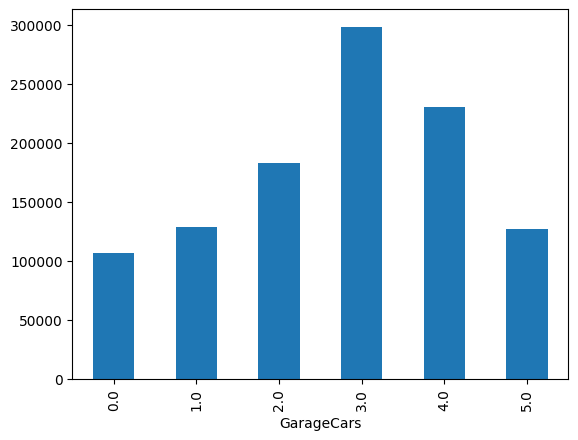

In [28]:
Ames.groupby(results_df.feature[3])['SalePrice'].mean().plot(kind="bar")
plt.show()

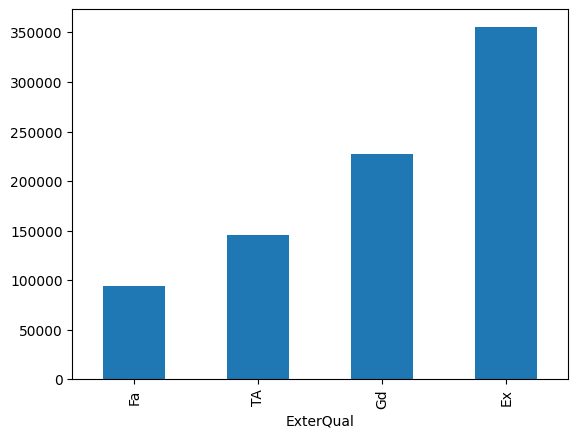

In [29]:
Ames.groupby(results_df.feature[4])['SalePrice'].mean().sort_values().plot(kind="bar")
plt.show()

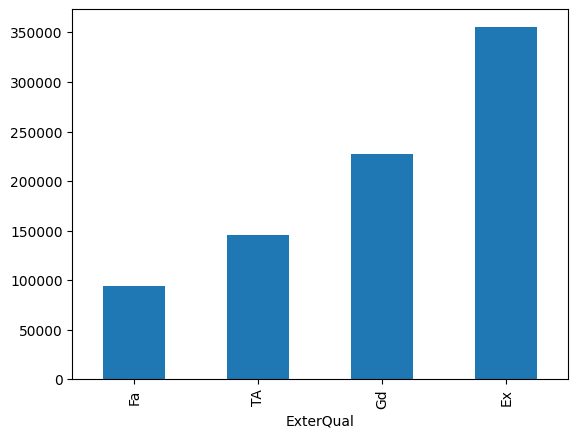

In [29]:
Ames.groupby(results_df.feature[4])['SalePrice'].mean().sort_values().plot(kind="bar")
plt.show()

In [64]:


# --- Helpers ---
def rmse_compat(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # works across sklearn versions
    return float(np.sqrt(mse))

def get_feature_names(X):
    if hasattr(X, "columns"):
        return list(X.columns)
    return [f"x{i}" for i in range(X.shape[1])]

# --- Main ---
def fit_multiple_linreg_all_features(
    X, y, *, test_size=0.2, random_state=42, n_splits=5, log_target=False
):
    """
    X: preprocessed feature matrix (DataFrame or ndarray), no NaNs
    y: target Series/array (SalePrice)
    log_target: if True, fits on log1p(y) and reports back-transformed RMSE too
    """
    feature_names = get_feature_names(X)

    # Target transform (optional)
    if log_target:
        y_trainable = np.log1p(y)
    else:
        y_trainable = np.asarray(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_trainable, test_size=test_size, random_state=random_state
    )

    # Fit
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Predict
    y_pred_test = lr.predict(X_test)
    y_pred_train = lr.predict(X_train)

    # Metrics (in target space)
    if log_target:
        # Back-transform for error metrics in dollars
        y_test_dollars = np.expm1(y_test)
        y_pred_test_dollars = np.expm1(y_pred_test)
        test_rmse = rmse_compat(y_test_dollars, y_pred_test_dollars)
        test_r2 = r2_score(y_test_dollars, y_pred_test_dollars)
    else:
        test_rmse = rmse_compat(y_test, y_pred_test)
        test_r2 = float(r2_score(y_test, y_pred_test))

    # Cross-validated RMSE (on full data)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    neg_mse = cross_val_score(lr, X, y_trainable, scoring="neg_mean_squared_error", cv=cv)
    if log_target:
        # Back-transform each fold's MSE is not available; report in log space as approx
        cv_rmse = float(np.sqrt(-neg_mse).mean())
        cv_rmse_std = float(np.sqrt(-neg_mse).std())
    else:
        cv_rmse = float(np.sqrt(-neg_mse).mean())
        cv_rmse_std = float(np.sqrt(-neg_mse).std())

    # Coefficients
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": lr.coef_,
        "abs_coef": np.abs(lr.coef_)
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)

    metrics = {
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "cv_rmse_mean": cv_rmse,
        "cv_rmse_std": cv_rmse_std,
        "intercept": float(lr.intercept_),
        "fitted_on_log_target": bool(log_target),
    }

    # Also return out-of-sample predictions (useful for residual checks)
    outputs = {
        "y_test_pred": y_pred_test if not log_target else y_pred_test_dollars,
        "y_test_true": y_test if not log_target else y_test_dollars,
    }

    return lr, coef_df, metrics, outputs

In [101]:
lr, coef_df, metrics, out = fit_multiple_linreg_all_features(X_final, Ames["SalePrice"], log_target=True)

In [102]:
print(metrics)

{'test_rmse': 20987.029752800558, 'test_r2': 0.9176448928145764, 'cv_rmse_mean': 0.10122483859088219, 'cv_rmse_std': 0.006142720828758496, 'intercept': 10.83499988039528, 'fitted_on_log_target': True}


In [33]:
residuals = pd.Series(out["y_test_true"] - out["y_test_pred"], name="residuals")

In [34]:
def coef_to_pct_change(coef_df):
    df_pct = coef_df.copy()
    df_pct["pct_change"] = (np.exp(df_pct["coef"]) - 1) * 100
    return df_pct[["feature", "coef", "pct_change"]].sort_values(
        "pct_change", key=abs, ascending=False
    ).reset_index(drop=True)

coef_pct_df = coef_to_pct_change(coef_df)

# coef_pct_df must already have columns: ["feature", "coef", "pct_change"]
# X_final is your design matrix used to fit the model

def is_one_hot(col: pd.Series) -> bool:
    vals = pd.unique(col.dropna())
    # allow 0/1 in int or float form
    return set(np.asarray(vals)).issubset({0, 1, 0.0, 1.0})

# 1) Annotate feature type + counts/coverage
feature_types = {}
counts = {}
pct_of_data = {}

n = len(X_final)

for feat in coef_pct_df["feature"]:
    if feat in X_final.columns:
        if is_one_hot(X_final[feat]):
            feature_types[feat] = "one-hot categorical"
            counts[feat] = int(X_final[feat].sum())
            pct_of_data[feat] = (counts[feat] / n) * 100.0
        else:
            feature_types[feat] = "numeric"
            counts[feat] = None
            pct_of_data[feat] = 100.0  # numeric features apply to all rows
    else:
        feature_types[feat] = "unknown"
        counts[feat] = None
        pct_of_data[feat] = np.nan

coef_pct_df["feature_type"] = coef_pct_df["feature"].map(feature_types)
coef_pct_df["count"] = coef_pct_df["feature"].map(counts)
coef_pct_df["pct_of_data"] = coef_pct_df["feature"].map(pct_of_data)

def rarity_label(row):
    if row["feature_type"] == "numeric":
        return "Numeric (N/A)"
    if pd.isna(row["pct_of_data"]):
        return "N/A"
    if row["pct_of_data"] < 1:
        return "Very rare (<1%)"
    if row["pct_of_data"] < 5:
        return "Rare (1–5%)"
    return "Common (≥5%)"

coef_pct_df["rarity"] = coef_pct_df.apply(rarity_label, axis=1)

# Sort by absolute % change
coef_pct_df = coef_pct_df.sort_values("pct_change", key=np.abs, ascending=False).reset_index(drop=True)

# 2) Filter to "common": numeric OR ≥ 5% coverage
common_mask = (coef_pct_df["feature_type"] == "numeric") | (coef_pct_df["pct_of_data"] >= 5)
common_coef_df = (
    coef_pct_df.loc[common_mask, ["feature", "feature_type", "pct_change", "count", "pct_of_data", "rarity"]]
    .sort_values("pct_change", key=np.abs, ascending=False)
    .reset_index(drop=True)
)

print("=== FULL LIST WITH RARITY ===")
display(coef_pct_df[["feature", "feature_type", "pct_change", "count", "pct_of_data", "rarity"]])

print("\n=== COMMON FEATURES (numeric OR ≥5% one-hot) ===")
display(common_coef_df)

=== FULL LIST WITH RARITY ===


,feature,feature_type,pct_change,count,pct_of_data,rarity
0,Neighborhood_GrnHill,one-hot categorical,4.536042e+01,2.0,0.077519,Very rare (<1%)
1,Condition2_PosN,one-hot categorical,-3.005731e+01,3.0,0.116279,Very rare (<1%)
2,MSSubClass_150,one-hot categorical,-2.228443e+01,1.0,0.038760,Very rare (<1%)
3,Exterior1st_PreCast,one-hot categorical,2.217233e+01,1.0,0.038760,Very rare (<1%)
4,Exterior2nd_PreCast,one-hot categorical,2.217233e+01,1.0,0.038760,Very rare (<1%)
...,...,...,...,...,...,...
253,Heating_Floor,one-hot categorical,4.440892e-14,1.0,0.038760,Very rare (<1%)
254,MSZoning_A (agr),one-hot categorical,0.000000e+00,1.0,0.038760,Very rare (<1%)
255,RoofMatl_Membran,one-hot categorical,0.000000e+00,1.0,0.038760,Very rare (<1%)
256,Neighborhood_Landmrk,one-hot categorical,0.000000e+00,1.0,0.038760,Very rare (<1%)



=== COMMON FEATURES (numeric OR ≥5% one-hot) ===


,feature,feature_type,pct_change,count,pct_of_data,rarity
0,Utilities,numeric,21.433810,NaN,100.000000,Numeric (N/A)
1,GrLivArea,numeric,10.486860,NaN,100.000000,Numeric (N/A)
2,Neighborhood_Edwards,one-hot categorical,-8.774969,165.0,6.395349,Common (≥5%)
3,MSSubClass_50,one-hot categorical,8.093026,259.0,10.038760,Common (≥5%)
4,LotArea,numeric,7.622406,NaN,100.000000,Numeric (N/A)
...,...,...,...,...,...,...
119,MasVnrType_BrkFace,one-hot categorical,-0.066859,804.0,31.162791,Common (≥5%)
120,BldgType_TwnhsE,one-hot categorical,0.043881,202.0,7.829457,Common (≥5%)
121,YrSold_2008,one-hot categorical,0.043177,564.0,21.860465,Common (≥5%)
122,Electrical,numeric,0.036406,NaN,100.000000,Numeric (N/A)


In [67]:
RANDOM_STATE = 42
CV_FOLDS = 5

# =========================
# 1) Utilities
# =========================
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def cv_eval_models(X, y, models, *, cv=CV_FOLDS, log_target=False, random_state=RANDOM_STATE):
    """
    Cross-validated evaluation with optional log-target training and dollar-scale metrics.

    Returns a DataFrame with:
      - cv_rmse_mean / cv_rmse_std  (in $)
      - r2_cv   (OOF R², in $)
      - r2_full (fit-on-all-data R², in $)
    """
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    rows = []
    for name, model in models:
        fold_rmses = []
        oof_pred = np.zeros(len(y_np), dtype=float)

        for tr_idx, va_idx in kf.split(X):
            X_tr, X_va = (X.iloc[tr_idx], X.iloc[va_idx]) if hasattr(X, "iloc") else (X[tr_idx], X[va_idx])
            y_tr, y_va = y_np[tr_idx], y_np[va_idx]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            model.fit(X_tr, y_tr_used)

            y_va_pred = model.predict(X_va)
            if log_target:
                y_va_pred = np.expm1(y_va_pred)

            fold_rmses.append(rmse(y_va, y_va_pred))
            oof_pred[va_idx] = y_va_pred

        r2_cv = r2_score(y_np, oof_pred)

        # Full-fit R² in $-space
        y_full_used = np.log1p(y_np) if log_target else y_np
        model.fit(X, y_full_used)
        y_full_pred = model.predict(X)
        if log_target:
            y_full_pred = np.expm1(y_full_pred)
        r2_full = r2_score(y_np, y_full_pred)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_cv),
            "r2_full": float(r2_full),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

# =========================
# 2) Penalized models: fit + interpretable coefs
# =========================
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.model_selection import KFold

def evaluate_penalized_models_stable(
    X, y, *,
    log_target=True,
    random_state=RANDOM_STATE,
    top_n=50,
    min_pct=5.0,
    include_full=False
):
    """
    Fits RidgeCV, LassoCV, ElasticNetCV. Returns metrics and filtered coef tables
    with % change (if log_target), feature types, and coverage.
    Keeps all numeric features and one-hot features present in ≥ min_pct of homes.
    """
    y_array = np.asarray(y)
    y_trainable = np.log1p(y_array) if log_target else y_array

    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    alphas = np.logspace(-3, 3, 50)
    # alphas = np.logspace(-4, 4, 80)
    l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

    ridge = RidgeCV(alphas=alphas, cv=cv, scoring="neg_mean_squared_error").fit(X, y_trainable)
    lasso = LassoCV(alphas=alphas, cv=cv, random_state=random_state, max_iter=100_000, tol=1e-3).fit(X, y_trainable)
    enet  = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=cv,
                         random_state=random_state, max_iter=100_000, tol=1e-3).fit(X, y_trainable)

    def _metrics(name, model, y_true, y_pred_train_space):
        if log_target:
            y_pred = np.expm1(y_pred_train_space)
            return {"model": name,
                    "alpha": getattr(model, "alpha_", None),
                    "l1_ratio": getattr(model, "l1_ratio_", None),
                    "rmse": rmse(y_true, y_pred),
                    "r2": float(r2_score(y_true, y_pred))}
        else:
            return {"model": name,
                    "alpha": getattr(model, "alpha_", None),
                    "l1_ratio": getattr(model, "l1_ratio_", None),
                    "rmse": rmse(y_true, y_pred_train_space),
                    "r2": float(r2_score(y_true, y_pred_train_space))}

    results = pd.DataFrame([
        _metrics("Ridge",      ridge, y_array, ridge.predict(X)),
        _metrics("Lasso",      lasso, y_array, lasso.predict(X)),
        _metrics("ElasticNet", enet,  y_array, enet.predict(X)),
    ])

    # coef tables
    feats = list(X.columns) if hasattr(X, "columns") else [f"x{i}" for i in range(X.shape[1])]

    def _coef_table(model):
        coef = np.asarray(model.coef_)
        df = pd.DataFrame({"feature": feats, "coef": coef})
        df["abs_coef"] = df["coef"].abs()
        return df.sort_values("abs_coef", ascending=False).head(top_n).reset_index(drop=True)

    raw_tables = {"Ridge": _coef_table(ridge), "Lasso": _coef_table(lasso), "ElasticNet": _coef_table(enet)}

    # feature typing & coverage
    def _is_one_hot(col: pd.Series) -> bool:
        vals = pd.unique(col.dropna())
        return set(np.asarray(vals)).issubset({0, 1, 0.0, 1.0})

    if hasattr(X, "columns"):
        n = len(X)
        is_dummy = {c: _is_one_hot(X[c]) for c in X.columns}
        coverage = {}
        for c in X.columns:
            if is_dummy[c]:
                col = X[c]
                # robust if any scaling slipped in
                cov = (col > 0.5).mean() if (np.issubdtype(col.dtype, np.number) and (col.max() > 1 or col.min() < 0)) else col.mean()
                coverage[c] = float(cov) * 100.0
            else:
                coverage[c] = 100.0
    else:
        is_dummy, coverage = {}, {}

    def _augment_and_filter(df):
        out = df.copy()
        out["pct_change"] = (np.exp(out["coef"]) - 1.0) * 100.0 if log_target else np.nan
        if hasattr(X, "columns"):
            out["feature_type"] = out["feature"].map(lambda f: "one-hot categorical" if is_dummy.get(f, False) else "numeric")
            out["pct_of_data"]  = out["feature"].map(lambda f: coverage.get(f, np.nan))
        else:
            out["feature_type"] = "unknown"; out["pct_of_data"] = np.nan
        mask = (out["feature_type"] == "numeric") | (out["pct_of_data"] >= min_pct)
        out = out[mask].copy()
        out = out.reindex(out[( "pct_change" if log_target else "abs_coef")].abs().sort_values(ascending=False).index)
        return out.reset_index(drop=True)

    filtered_tables = {name: _augment_and_filter(df) for name, df in raw_tables.items()}

    if include_full:
        return results, filtered_tables, raw_tables
    else:
        return results, filtered_tables

# =========================
# 3) Consensus table & plot (penalized models)
# =========================
def build_consensus_table(ridge_df: pd.DataFrame,
                          lasso_df: pd.DataFrame,
                          enet_df: pd.DataFrame,
                          min_models: int = 2) -> pd.DataFrame:
    def _prep(df, tag):
        return df[["feature", "feature_type", "pct_change", "pct_of_data"]].rename(
            columns={"pct_change": f"{tag}_pct", "pct_of_data": f"{tag}_pct_of_data"}
        )
    merged = _prep(ridge_df, "Ridge").merge(_prep(lasso_df, "Lasso"), on=["feature","feature_type"], how="outer") \
                                     .merge(_prep(enet_df, "ElasticNet"), on=["feature","feature_type"], how="outer")
    model_cols = ["Ridge_pct", "Lasso_pct", "ElasticNet_pct"]
    merged["n_models"] = merged[model_cols].notna().sum(axis=1)
    merged = merged[merged["n_models"] >= min_models].copy()
    merged["avg_pct_change"] = merged[model_cols].mean(axis=1, skipna=True)
    merged["std_pct_change"] = merged[model_cols].std(axis=1, ddof=0, skipna=True)
    coverage_cols = ["Ridge_pct_of_data", "Lasso_pct_of_data", "ElasticNet_pct_of_data"]
    merged["pct_of_data"] = merged[coverage_cols].max(axis=1, skipna=True)
    return merged.sort_values("avg_pct_change", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)

def plot_consensus_bar(consensus_df: pd.DataFrame, top_n: int = 15, with_errorbars: bool = True, figsize=(9,6),
                       title="Consensus Feature Importance (Penalized Models)"):
    df = consensus_df.head(top_n).copy().sort_values("avg_pct_change", ascending=True)
    plt.figure(figsize=figsize)
    bars = plt.barh(df["feature"], df["avg_pct_change"])
    for b, val in zip(bars, df["avg_pct_change"]):
        b.set_color("tab:red" if val < 0 else "tab:green")
    if with_errorbars and "std_pct_change" in df.columns:
        x = df["avg_pct_change"].values
        err = df["std_pct_change"].fillna(0).values
        y = np.arange(len(df))
        plt.errorbar(x, y, xerr=err, fmt="none", ecolor="gray", capsize=3, linewidth=1)
    plt.axvline(0, color="black", lw=0.8)
    plt.xlabel("Average % Change in Price (per 1 SD or category)")
    plt.ylabel("Feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# =========================
# 4) Models & example usage
# =========================
# NOTE:
# - Use X_final (scaled numerics) for linear models; use X_raw (unscaled) for trees if you have it.
# - y_final should be RAW SalePrice; set log_target=True to train in log space with $-scale metrics.

alphas = np.logspace(-3, 1, 40)
l1_grid = [0.1, 0.3, 0.5, 0.7, 0.9]

# models = [
#     ("Ridge",        Ridge(alpha=14.56)),
#     ("LassoCV",      LassoCV(alphas=alphas, cv=CV_FOLDS, max_iter=100_000, tol=1e-3, n_jobs=-1)),
#     ("ElasticNetCV", ElasticNetCV(alphas=alphas, l1_ratio=l1_grid, cv=CV_FOLDS, max_iter=100_000, tol=1e-3, random_state=RANDOM_STATE)),
#     ("RandomForest", RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE, n_jobs=1)),  # avoid nested parallel
#     ("HistGB",       HistGradientBoostingRegressor(random_state=RANDOM_STATE)),
#     ("SVR",          SVR(kernel='rbf', C=10, epsilon=0.2)),
# ]


models = [
    ("Ridge",        RidgeCV(alphas=alphas, cv=CV_FOLDS, scoring="neg_mean_squared_error")),
    ("LassoCV",      LassoCV(alphas=alphas, cv=CV_FOLDS, max_iter=100_000, tol=1e-3, n_jobs=-1)),
    ("ElasticNetCV", ElasticNetCV(alphas=alphas, l1_ratio=l1_grid, cv=CV_FOLDS, max_iter=100_000, tol=1e-3, random_state=RANDOM_STATE)),
]

In [ ]:
FULL RUN

In [472]:

# --- Penalized models + consensus (log target recommended) ---
results_df, coef_tables = evaluate_penalized_models_stable(X_final, Ames["SalePrice"], log_target=True, min_pct=5, top_n=200)
print(results_df)

y_final = Ames["SalePrice"]

s= time.time()
print("\n=== LOG target leaderboard ===")
print(cv_eval_models(X_final, y_final, models, cv=CV_FOLDS, log_target=True,  random_state=RANDOM_STATE).to_string(index=False))

print((time.time() -s), 'sec')

        model      alpha  l1_ratio          rmse        r2
0       Ridge  19.306977       NaN  16791.977915  0.944181
1       Lasso   0.001000       NaN  18903.756991  0.929259
2  ElasticNet   0.001000       0.1  16523.205812  0.945954

=== LOG target leaderboard ===
       model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
ElasticNetCV  18660.953790  2118.304054 0.930176 0.942817
       Ridge  18677.015398  2254.998977 0.929939 0.944433
     LassoCV  18769.926450  2187.047911 0.929310 0.939817
30.426517009735107 sec


In [475]:
import time
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
# uses your existing: cv_eval_models(X, y, models, ...)

t0 = time.time()
RANDOM_STATE = 42
CV_OUTER = 10  # outer folds in your cv_eval_models

# --- compact, targeted inner search spaces ---
ridge_alphas = np.linspace(8, 20, 13)              # around your best ~12
lasso_alphas = np.r_[np.logspace(-4, -3, 5),       # 1e-4 … 1e-3
                     np.linspace(0.0012, 0.01, 8)] # densify near prior best
enet_alphas  = lasso_alphas
enet_l1      = [0.2, 0.4, 0.6]                     # slim but representative
# enet_l1 = np.linspace(0.2, 0.9, 8)  # denser sweep

# --- fast inner CV configs ---
ridge_fast = RidgeCV(alphas=ridge_alphas, cv=None)  # GCV = fast & accurate
inner5 = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lasso_fast = LassoCV(
    alphas=lasso_alphas, cv=inner5,
    max_iter=100_000, tol=1e-3, random_state=RANDOM_STATE, n_jobs=-1
)

enet_fast  = ElasticNetCV(
    alphas=enet_alphas, l1_ratio=enet_l1, cv=inner5,
    max_iter=100_000, tol=1e-3, random_state=RANDOM_STATE, n_jobs=-1
)

models = [
    ("Ridge",        ridge_fast),
    ("LassoCV",      lasso_fast),
    ("ElasticNetCV", enet_fast),
]

print("\n=== LOG target leaderboard (lean inner-CV) ===")
print(cv_eval_models(X_final, Ames["SalePrice"], models, cv=CV_OUTER, log_target=True,
                     random_state=RANDOM_STATE).to_string(index=False))

print(f"\nElapsed: {(time.time()-t0):.2f} sec")


=== LOG target leaderboard (lean inner-CV) ===
       model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
       Ridge  18496.588246  2776.502601 0.930747 0.944433
ElasticNetCV  18569.840548  2673.163752 0.930321 0.942817
     LassoCV  18583.714239  2676.579991 0.930216 0.939817

Elapsed: 51.12 sec


In [474]:
import time
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet

t0 = time.time()
RANDOM_STATE = 42
CV_OUTER = 10  # outer CV in your cv_eval_models

# ---- ultra-fast inner search spaces ----
# Ridge tends to like larger alphas; GCV is fast and stable
ridge_alphas = np.logspace(0.8, 1.5, 12)   # ~6.3 to ~31.6

# L1-family usually likes smaller alphas on standardized X
lasso_alphas = np.logspace(-5, -3, 7)      # 1e-5 … 1e-3 (tiny, focused)
enet_alphas  = lasso_alphas
enet_l1      = [0.1, 0.2, 0.4, 0.6]        # slim but representative

# ---- inner CV configs (small for speed) ----
inner3 = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

ridge_fast = RidgeCV(alphas=ridge_alphas, cv=None, scoring="neg_mean_squared_error")

lasso_fast = LassoCV(
    alphas=lasso_alphas, cv=inner3,
    max_iter=150_000, tol=1e-3,
    random_state=RANDOM_STATE, n_jobs=-1, selection="cyclic"
)

enet_fast  = ElasticNetCV(
    alphas=enet_alphas, l1_ratio=enet_l1, cv=inner3,
    max_iter=150_000, tol=1e-3,
    random_state=RANDOM_STATE, n_jobs=-1, selection="cyclic"
)

models = [
    ("Ridge",        ridge_fast),
    ("LassoCV",      lasso_fast),
    ("ElasticNetCV", enet_fast),
]

print("\n=== LOG target leaderboard (FAST tuner) ===")
print(cv_eval_models(
    X_final, Ames["SalePrice"], models,
    cv=CV_OUTER, log_target=True, random_state=RANDOM_STATE
).to_string(index=False))

print(f"\nElapsed: {(time.time()-t0):.2f} sec")


=== LOG target leaderboard (FAST tuner) ===
       model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
       Ridge  18500.890789  2784.025268 0.930708 0.944513
ElasticNetCV  18543.034775  2657.959750 0.930534 0.943895
     LassoCV  18599.880192  2673.112227 0.930100 0.943332

Elapsed: 63.68 sec


In [305]:
df = Ames.copy()

df = ames_df[ames_df["RanchColonial"].isin(["Ranch", "Colonial"])].copy()
df["LogPrice"] = np.log1p(df["SalePrice"])

import statsmodels.formula.api as smf

formula = "LogPrice ~ C(RanchColonial) + OverallQual + GrLivArea + GarageCars + FullBath"
model = smf.ols(formula, data=df).fit()
print(model.summary())

coef = model.params["C(RanchColonial)[T.Ranch]"]
print(f"Ranch vs Colonial: Ranch homes sell for ~{(np.exp(coef)-1)*100:.1f}% less, controlling for features.")

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     2258.
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:15:27   Log-Likelihood:                 1040.2
No. Observations:                2276   AIC:                            -2068.
Df Residuals:                    2270   BIC:                            -2034.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [306]:
# Which of the house styles, ranch or colonial, is more popular in terms of the house prices?

import statsmodels.formula.api as smf

# Filter Ranch vs Colonial
df = ames_df[ames_df["RanchColonial"].isin(["Ranch", "Colonial"])].copy()
df["LogPrice"] = np.log1p(df["SalePrice"])

formula = """
LogPrice ~ C(RanchColonial)
+ OverallQual + OverallCond
+ GrLivArea + TotalBsmtSF + LotArea
+ FullBath + HalfBath + BedroomAbvGr
+ GarageCars + GarageArea
+ YearBuilt + YearRemodAdd
+ C(Neighborhood)
"""

model = smf.ols(formula, data=df).fit(cov_type="HC3")  # robust SEs
print(model.summary())

coef = model.params["C(RanchColonial)[T.Ranch]"]
print(f"\nRanch vs Colonial (expanded controls): Ranch homes sell for ~{(np.exp(coef)-1)*100:.1f}% less, controlling for features.")

                            OLS Regression Results                            
Dep. Variable:               LogPrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     1498.
Date:                Tue, 19 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:17:14   Log-Likelihood:                 1800.9
No. Observations:                2275   AIC:                            -3520.
Df Residuals:                    2234   BIC:                            -3285.
Df Model:                          40                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [478]:
df_nc = ames_df[
    (ames_df["HouseStyle"] != "1Story") &
    (ames_df["RanchColonial"].isin(["Colonial", "Ranch"]))
].copy()

df_nc = df_nc.rename(columns={"2ndFlrSF": "SecondFlrSF"})

import statsmodels.formula.api as smf

model = smf.ols(
    formula="SalePrice ~ SecondFlrSF * RanchColonial",
    data=df_nc
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     226.9
Date:                Wed, 20 Aug 2025   Prob (F-statistic):          6.69e-112
Time:                        14:40:56   Log-Likelihood:                -12154.
No. Observations:                 989   AIC:                         2.432e+04
Df Residuals:                     985   BIC:                         2.434e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 1.526e+05   2327.541     65.566      0.000    1.48e+05    1.57e+05
C(RanchColonial)[T.Colonial]             -1.123e+05   9253.165    -12.132      0.000    -1.3e+05   -9.41e+04
SecondFlrSF                                 37.8627      8.802      4.301      0.000      20.610      55.115
SecondFlrSF:C(RanchColonial)[T.Colonial]   146.9682     13.766     10.676      0.000     119.987     173.949

--- Price sensitivity to SecondFlrSF (simple linear OLS, robust SE) ---
Ranch:     $38 per additional 2nd-floor sqft  (p = 0.0000)
Colonial:  $185 per additional 2nd-floor sqft
Difference (Colonial − Ranch) driven by interaction term p = 0.0000

Interpretation: Colonials are significantly more sensitive to 2nd-floor area than Ranch homes.


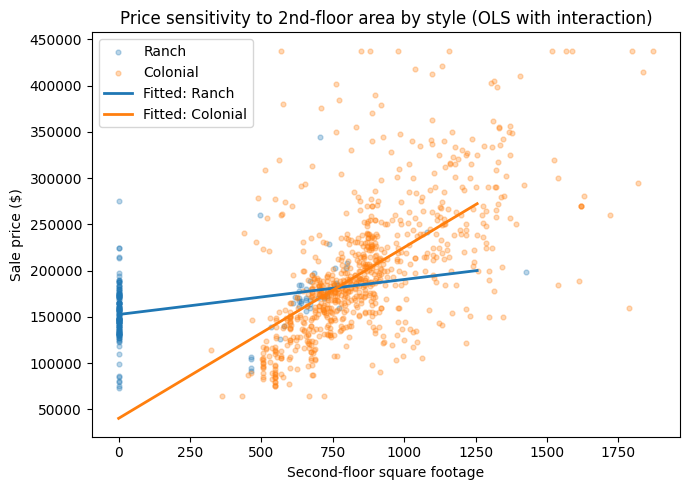

In [324]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.contrast import ContrastResults

# ---- 0) Prep: copy, rename col with a safe name for formulas, filter to 2+ story ----
df = ames_df.copy()
if "2ndFlrSF" in df.columns:
    df = df.rename(columns={"2ndFlrSF": "SecondFlrSF"})

# keep only non-1Story homes and rows we need
need_cols = ["SalePrice", "SecondFlrSF", "RanchColonial", "HouseStyle"]
df = df.loc[df["HouseStyle"].ne("1Story"), need_cols].dropna()

# make sure the style column is categorical with Ranch as the baseline (so Colonial is the contrast)
df["RanchColonial"] = pd.Categorical(df["RanchColonial"], categories=["Ranch","Colonial"])

# ---- 1) Fit the interaction model (simple version: no extra controls) ----
# If you want log target instead, change SalePrice -> np.log(SalePrice) and exponentiate interpretations.
model = smf.ols("SalePrice ~ SecondFlrSF * C(RanchColonial)", data=df).fit(cov_type="HC1")  # robust SE

print(model.summary().tables[1])  # coef table only

# ---- 2) Extract slopes by style ----
# Model: SalePrice = b0 + b1*SecondFlrSF + b2*I(Colonial) + b3*SecondFlrSF*I(Colonial) + e
b = model.params
p = model.pvalues

# slope ($ per sqft of SecondFlrSF) for Ranch (baseline)
slope_ranch = b["SecondFlrSF"]
p_ranch     = p["SecondFlrSF"]

# slope for Colonial = b1 + b3
b3_name = "SecondFlrSF:C(RanchColonial)[T.Colonial]"
slope_colonial = b["SecondFlrSF"] + b[b3_name]
# p-value for the interaction term tells you whether the slopes differ
p_inter = p[b3_name]

# ---- 3) Pretty print interpretation ----
def fmt_money(x): 
    return f"${x:,.0f}"

print("\n--- Price sensitivity to SecondFlrSF (simple linear OLS, robust SE) ---")
print(f"Ranch:     {fmt_money(slope_ranch)} per additional 2nd-floor sqft  (p = {p_ranch:.4f})")
print(f"Colonial:  {fmt_money(slope_colonial)} per additional 2nd-floor sqft")
print(f"Difference (Colonial − Ranch) driven by interaction term p = {p_inter:.4f}")

if p_inter < 0.05:
    if slope_colonial > slope_ranch:
        verdict = "Colonials are significantly more sensitive to 2nd-floor area than Ranch homes."
    else:
        verdict = "Colonials are significantly less sensitive to 2nd-floor area than Ranch homes."
else:
    verdict = "No statistically significant evidence that price sensitivity to 2nd-floor area differs by style."

print("\nInterpretation:", verdict)

# ---- 4) (Optional) add a simple visualization of fitted lines ----
try:
    import matplotlib.pyplot as plt
    xs = np.linspace(df["SecondFlrSF"].quantile(0.05), df["SecondFlrSF"].quantile(0.95), 50)
    # fitted lines at mean intercept for each style
    # Ranch: y = b0 + b1*x
    y_ranch = (b["Intercept"] + slope_ranch*xs)
    # Colonial: y = (b0 + b2) + (b1 + b3)*x
    y_col = (b["Intercept"] + b["C(RanchColonial)[T.Colonial]"]) + slope_colonial*xs

    plt.figure(figsize=(7,5))
    plt.scatter(df.loc[df["RanchColonial"]=="Ranch","SecondFlrSF"],
                df.loc[df["RanchColonial"]=="Ranch","SalePrice"], s=12, alpha=0.3, label="Ranch")
    plt.scatter(df.loc[df["RanchColonial"]=="Colonial","SecondFlrSF"],
                df.loc[df["RanchColonial"]=="Colonial","SalePrice"], s=12, alpha=0.3, label="Colonial")
    plt.plot(xs, y_ranch, label="Fitted: Ranch", linewidth=2)
    plt.plot(xs, y_col, label="Fitted: Colonial", linewidth=2)
    plt.xlabel("Second-floor square footage")
    plt.ylabel("Sale price ($)")
    plt.title("Price sensitivity to 2nd-floor area by style (OLS with interaction)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass

                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                 9.468e+04   3.72e+04      2.547      0.011    2.18e+04    1.68e+05
C(RanchColonial)[T.Colonial]             -5.434e+04   3.82e+04     -1.421      0.155   -1.29e+05    2.06e+04
SecondFlrSF                                118.7069     54.027      2.197      0.028      12.816     224.598
SecondFlrSF:C(RanchColonial)[T.Colonial]    66.1240     55.055      1.201      0.230     -41.781     174.029

--- Price sensitivity to SecondFlrSF (simple linear OLS, robust SE) ---
Ranch:     $119 per additional 2nd-floor sqft  (p = 0.0280)
Colonial:  $185 per additional 2nd-floor sqft
Difference (Colonial − Ranch) driven by interaction term p = 0.2297

Interpretation: No statistically significant evidence that price sensitivity to 2nd-floor area dif

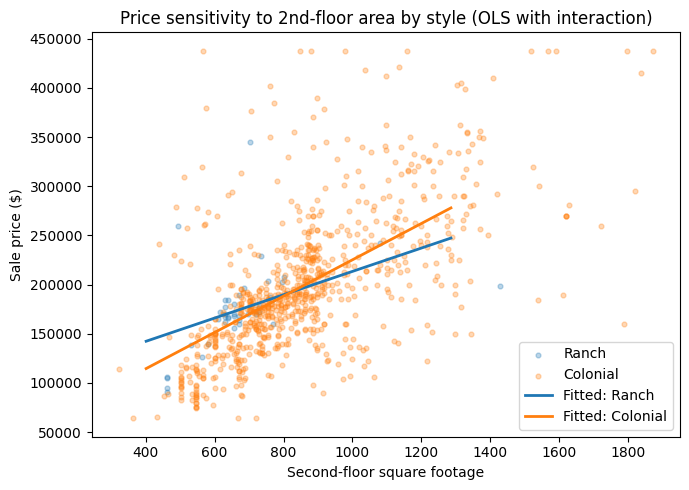

In [404]:
# ---- 0) Prep: copy, rename col with a safe name for formulas, filter ----
df = ames_df.copy()
if "2ndFlrSF" in df.columns:
    df = df.rename(columns={"2ndFlrSF": "SecondFlrSF"})

# keep only non-1Story homes AND those with positive 2nd-floor sqft
need_cols = ["SalePrice", "SecondFlrSF", "RanchColonial", "HouseStyle"]
df = df.loc[(df["HouseStyle"].ne("1Story")) & (df["SecondFlrSF"] > 0), need_cols].dropna()

# make RanchColonial categorical with Ranch baseline
df["RanchColonial"] = pd.Categorical(df["RanchColonial"], categories=["Ranch","Colonial"])

# ---- 1) Fit interaction model ----
model = smf.ols("SalePrice ~ SecondFlrSF * C(RanchColonial)", data=df).fit(cov_type="HC1")

print(model.summary().tables[1])

# ---- 2) Extract slopes by style ----
# Model: SalePrice = b0 + b1*SecondFlrSF + b2*I(Colonial) + b3*SecondFlrSF*I(Colonial) + e
b = model.params
p = model.pvalues

# slope ($ per sqft of SecondFlrSF) for Ranch (baseline)
slope_ranch = b["SecondFlrSF"]
p_ranch     = p["SecondFlrSF"]

# slope for Colonial = b1 + b3
b3_name = "SecondFlrSF:C(RanchColonial)[T.Colonial]"
slope_colonial = b["SecondFlrSF"] + b[b3_name]
# p-value for the interaction term tells you whether the slopes differ
p_inter = p[b3_name]

# ---- 3) Pretty print interpretation ----
def fmt_money(x): 
    return f"${x:,.0f}"

print("\n--- Price sensitivity to SecondFlrSF (simple linear OLS, robust SE) ---")
print(f"Ranch:     {fmt_money(slope_ranch)} per additional 2nd-floor sqft  (p = {p_ranch:.4f})")
print(f"Colonial:  {fmt_money(slope_colonial)} per additional 2nd-floor sqft")
print(f"Difference (Colonial − Ranch) driven by interaction term p = {p_inter:.4f}")

if p_inter < 0.05:
    if slope_colonial > slope_ranch:
        verdict = "Colonials are significantly more sensitive to 2nd-floor area than Ranch homes."
    else:
        verdict = "Colonials are significantly less sensitive to 2nd-floor area than Ranch homes."
else:
    verdict = "No statistically significant evidence that price sensitivity to 2nd-floor area differs by style."

print("\nInterpretation:", verdict)

# ---- 4) (Optional) add a simple visualization of fitted lines ----
try:
    import matplotlib.pyplot as plt
    xs = np.linspace(df["SecondFlrSF"].quantile(0.05), df["SecondFlrSF"].quantile(0.95), 50)
    # fitted lines at mean intercept for each style
    # Ranch: y = b0 + b1*x
    y_ranch = (b["Intercept"] + slope_ranch*xs)
    # Colonial: y = (b0 + b2) + (b1 + b3)*x
    y_col = (b["Intercept"] + b["C(RanchColonial)[T.Colonial]"]) + slope_colonial*xs

    plt.figure(figsize=(7,5))
    plt.scatter(df.loc[df["RanchColonial"]=="Ranch","SecondFlrSF"],
                df.loc[df["RanchColonial"]=="Ranch","SalePrice"], s=12, alpha=0.3, label="Ranch")
    plt.scatter(df.loc[df["RanchColonial"]=="Colonial","SecondFlrSF"],
                df.loc[df["RanchColonial"]=="Colonial","SalePrice"], s=12, alpha=0.3, label="Colonial")
    plt.plot(xs, y_ranch, label="Fitted: Ranch", linewidth=2)
    plt.plot(xs, y_col, label="Fitted: Colonial", linewidth=2)
    plt.xlabel("Second-floor square footage")
    plt.ylabel("Sale price ($)")
    plt.title("Price sensitivity to 2nd-floor area by style (OLS with interaction)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass


In [480]:
model = ridge_fast
model_name = model.__class__.__name__

model.fit(X_final, np.log1p(Ames["SalePrice"]))  # log target
coef = pd.Series(model.coef_, index=X_final.columns)

beta_full  = coef["FullBath"]
beta_half  = coef["HalfBath"]
beta_full_b  = coef["BsmtFullBath"]
beta_half_b  = coef["BsmtHalfBath"]


mask = (Ames["BsmtQual"].isin(["TA","Gd","Ex"])) & (Ames["BsmtFinSF1"] > 0)
X_sub, y_sub = X_final[mask], Ames.loc[mask, "SalePrice"]

model.fit(X_sub, np.log1p(y_sub))  # log target
coef = pd.Series(model.coef_, index=X_final.columns)

beta_full_mask  = coef["FullBath"]
beta_half_mask  = coef["HalfBath"]
beta_full_b_mask  = coef["BsmtFullBath"]
beta_half_b_mask  = coef["BsmtHalfBath"]


half_weight = beta_half / beta_full if beta_full != 0 else np.nan
half_weight_b = beta_half_b_mask / beta_full_b_mask if beta_full != 0 else np.nan
b_weight = beta_full_b_mask / beta_full if beta_full != 0 else np.nan
b_weight_half = beta_half_b_mask / beta_full
print(model_name + " HalfBath weight vs FullBath:", half_weight)
print(model_name + " Basement HalfBath weight vs Basement FullBath:", half_weight_b)
print(model_name + " Basement FullBath weight vs FullBath:", b_weight)
print(model_name + " Basement HalfBath weight vs FullBath:", b_weight_half)

RidgeCV HalfBath weight vs FullBath: 0.5618140747547741
RidgeCV Basement HalfBath weight vs Basement FullBath: 0.2247784229704327
RidgeCV Basement FullBath weight vs FullBath: 0.8241238942137323
RidgeCV Basement HalfBath weight vs FullBath: 0.18524526927361448


In [8]:
import numpy as np
import pandas as pd
from joblib import parallel_backend
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import (
    HistGradientBoostingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, GradientBoostingRegressor
)

# ---------- helpers ----------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def _make_ttr(est):
    # Train on log1p(y), return predictions in $-space
    return TransformedTargetRegressor(regressor=est, func=np.log1p, inverse_func=np.expm1)

def cv_eval_models_nonlinear(
    X_raw, y, *, cv=5, random_state=42, models=None, use_threads=True
):
    """
    Cross-validated evaluation for NON-LINEAR (tree-based) models on RAW / one-hot features.
    Do NOT standardize numeric features.
    Uses TTR so metrics are in $-space without manual log handling.
    """
    # Ensure dense DataFrame/ndarray for HGB; convert sparse to dense once if needed
    if hasattr(X_raw, "toarray"):
        X_use = pd.DataFrame(X_raw.toarray(), index=getattr(X_raw, "index", None))
    else:
        X_use = X_raw

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # Default model set (lean, stable)
    if models is None:
        models = [
            ("HistGB", _make_ttr(HistGradientBoostingRegressor(
                random_state=random_state,
                max_depth=None,          # leave flexible; we’re just benchmarking
                max_bins=255,            # robust default
            ))),
            ("RandomForest", _make_ttr(RandomForestRegressor(
                n_estimators=600, max_features=0.3,
                min_samples_leaf=1, bootstrap=True,
                n_jobs=-1, random_state=random_state
            ))),
            ("ExtraTrees", _make_ttr(ExtraTreesRegressor(
                n_estimators=600, max_features=0.5,
                min_samples_leaf=1, bootstrap=False,
                n_jobs=-1, random_state=random_state
            ))),
            ("GradBoost", _make_ttr(GradientBoostingRegressor(
                random_state=random_state
            ))),
        ]

    results = []
    ctx = parallel_backend("threading") if use_threads else nullcontext()  # threading avoids loky issues
    with ctx:
        for name, model in models:
            fold_rmses = []
            oof_pred = np.zeros(len(y_np), dtype=float)

            for tr_idx, va_idx in kf.split(X_use):
                X_tr = X_use.iloc[tr_idx] if hasattr(X_use, "iloc") else X_use[tr_idx]
                X_va = X_use.iloc[va_idx] if hasattr(X_use, "iloc") else X_use[va_idx]
                y_tr, y_va = y_np[tr_idx], y_np[va_idx]

                model.fit(X_tr, y_tr)             # TTR: fits on log(y) internally
                y_va_pred = model.predict(X_va)    # returns $-space
                fold_rmses.append(rmse(y_va, y_va_pred))
                oof_pred[va_idx] = y_va_pred

            r2_cv = r2_score(y_np, oof_pred)

            # Fit on all for r2_full (still in $-space)
            model.fit(X_use, y_np)
            y_full_pred = model.predict(X_use)
            r2_full = r2_score(y_np, y_full_pred)

            results.append({
                "model": name,
                "cv_rmse_mean": float(np.mean(fold_rmses)),
                "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
                "r2_cv":  float(r2_cv),
                "r2_full": float(r2_full),
            })

    return pd.DataFrame(results).sort_values("cv_rmse_mean").reset_index(drop=True)

In [10]:
X_raw = transformed_df.copy()
y_final = Ames.SalePrice
print(cv_eval_models_nonlinear(X_raw, y_final, cv=5, random_state=42))

          model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0        HistGB  19379.367080  1268.265364  0.925336  0.985526
1     GradBoost  20068.052558  1732.083133  0.919683  0.959206
2    ExtraTrees  21043.995361  1249.987741  0.912024  0.999999
3  RandomForest  21046.585248  1123.814266  0.912062  0.987909


In [11]:
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# -------- helpers --------
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

neg_rmse = make_scorer(rmse, greater_is_better=False)

def make_ttr(est):
    # train on log1p(y), predict back in $ space
    return TransformedTargetRegressor(regressor=est, func=np.log1p, inverse_func=np.expm1)

# -------- fast, targeted tuner for HistGB --------
def tune_histgb_fast(
    X, y,
    random_state=42,
    n_iter=24,                 # keep it lean; bump to ~40 if you want a bit more search
    cv_splits=5,
    n_jobs=1                   # keep 1 to avoid loky/resource_tracker weirdness; try -1 if your env is stable
):
    inner_cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Narrow distributions centered near what’s worked well for you
    param_dist = {
        "regressor__learning_rate":  np.linspace(0.03, 0.08, 10),
        "regressor__max_iter":       np.arange(700, 1601, 100),
        "regressor__max_depth":      [3, 4, 5, 6],          # shallow-to-mid trees generalize best here
        "regressor__min_samples_leaf":[5, 8, 10, 15, 20],
        "regressor__max_bins":       [64, 96, 128],
        "regressor__l2_regularization": [0.0, 0.05, 0.1, 0.2, 0.3],
    }

    base = HistGradientBoostingRegressor(
        random_state=random_state,
        # keep defaults for early_stopping='auto' (ignored in CV), monotonic_cst=None, etc.
    )

    search = RandomizedSearchCV(
        estimator=make_ttr(base),
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=neg_rmse,            # RMSE in $ space
        cv=inner_cv,
        n_jobs=n_jobs,
        verbose=0,
        random_state=random_state,
        refit=True
    )

    t0 = time.time()
    search.fit(X, y)
    secs = time.time() - t0

    # Unwrap best params for readability
    best = {k.replace("regressor__", ""): v for k, v in search.best_params_.items()}
    best_rmse = -search.best_score_

    print(f"[HistGB FAST tune] Best CV RMSE: {best_rmse:,.0f} $ | params={best}  ({secs:.1f}s)")

    # quick confirm with a clean 5-fold on the best estimator (already refit on all data)
    # If you want OOF metrics here, re-run a quick KFold loop; keeping it short for speed:
    return search.best_estimator_, best, best_rmse

In [12]:
# X_raw or your refined top-K feature matrix (non-scaled numerics + one-hots)
best_hgb, best_params, best_cv_rmse = tune_histgb_fast(X_raw, y_final, n_iter=24, cv_splits=5, n_jobs=-1)

[HistGB FAST tune] Best CV RMSE: 18,197 $ | params={'min_samples_leaf': 5, 'max_iter': np.int64(1400), 'max_depth': 4, 'max_bins': 128, 'learning_rate': np.float64(0.04111111111111111), 'l2_regularization': 0.0}  (52.1s)


In [ ]:
# X_raw is your transformed_df (one-hot + numeric, unscaled for trees)
X_raw = transformed_df.copy()

need = ["GrLivArea","OverallQual","TotalSF","TotalBaths","GarageCars",
        "HouseAge","HouseAgeSinceRemod"]
missing = [c for c in need if c not in X_raw.columns]
if missing:
    raise KeyError(f"These columns are missing from transformed_df: {missing}")

# Numeric × Numeric interactions
X_raw["GrLivArea_x_Qual"]   = X_raw["GrLivArea"]   * X_raw["OverallQual"]
X_raw["TotalSF_x_Qual"]     = X_raw["TotalSF"]     * X_raw["OverallQual"]
X_raw["Baths_x_Garage"]     = X_raw["TotalBaths"]  * X_raw["GarageCars"]
X_raw["Age_x_Qual"]         = X_raw["HouseAge"]    * X_raw["OverallQual"]
X_raw["AgeRemod_x_Qual"]    = X_raw["HouseAgeSinceRemod"] * X_raw["OverallQual"]

# Optional: clean any inf/NaN created by odd values
X_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
X_raw.fillna(0, inplace=True)

print("X_raw with numeric interactions:", X_raw.shape)

In [486]:
import time
import numpy as np
from joblib import parallel_backend
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

RANDOM_STATE = 42

def make_ttr(est):
    # log-target wrapper so we score in $ space directly
    return TransformedTargetRegressor(regressor=est, func=np.log1p, inverse_func=np.expm1)

# ---- Tight search space built from your past bests ----
param_dist = {
    "regressor__learning_rate":   [0.04, 0.05, 0.055, 0.06, 0.07],
    "regressor__max_depth":       [3, 4],            # you’ve seen 3–4 winning
    "regressor__max_iter":        [900, 1100, 1200, 1400],
    "regressor__min_samples_leaf":[5, 8, 10, 12],
    "regressor__max_bins":        [64, 96],
    "regressor__l2_regularization":[0.05, 0.1, 0.2, 0.3],
}

inner_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)  # fast inner CV
outer_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)  # report number

hgb = make_ttr(HistGradientBoostingRegressor(random_state=RANDOM_STATE))

search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_dist,
    n_iter=16,                         # small, targeted
    scoring="neg_root_mean_squared_error",
    cv=inner_cv,
    n_jobs=-1,                         # we’ll force threads below
    random_state=RANDOM_STATE,
    verbose=0,
    pre_dispatch="2*n_jobs",
    return_train_score=False
)

t0 = time.time()
with parallel_backend("threading", n_jobs=-1):      # avoid loky multi-process overhead
    search.fit(X_raw, y_final)
tune_secs = time.time() - t0

best_hgb = search.best_estimator_
print("[FAST HGB] best params:", {k.replace("regressor__", ""): v for k, v in search.best_params_.items()})
print(f"[FAST HGB] inner-CV RMSE: {-search.best_score_:,.0f}  (tuned in {tune_secs:.1f}s)")

# Re-score with a proper 5-fold CV (still fast)
t1 = time.time()
with parallel_backend("threading", n_jobs=-1):
    cv_scores = cross_val_score(best_hgb, X_raw, y_final, scoring="neg_root_mean_squared_error", cv=outer_cv, n_jobs=-1)
rmse_mean = -cv_scores.mean()
rmse_std  = cv_scores.std()

# Compute R² from CV quickly by reusing the folds once (approx; or keep your existing evaluator)
from sklearn.metrics import r2_score
r2_list = []
for tr, va in outer_cv.split(X_raw):
    Xtr, Xva = X_raw.iloc[tr], X_raw.iloc[va]
    ytr, yva = y_final.iloc[tr], y_final.iloc[va]
    best_hgb.fit(Xtr, ytr)  # TTR handles log(y)
    pred = best_hgb.predict(Xva)
    r2_list.append(r2_score(yva, pred))
r2_mean = float(np.mean(r2_list))
r2_std  = float(np.std(r2_list))
print(f"[FAST HGB] 5-fold RMSE: {rmse_mean:,.0f}  (±{rmse_std:,.0f})   R²: {r2_mean:.6f}  (±{r2_std:.6f})   ({time.time()-t1:.1f}s)")

KeyboardInterrupt: 

In [17]:
# --- Nonlinear tuning + evaluation (robust/threads) ---
import time
import numpy as np
from joblib import parallel_backend
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

RANDOM_STATE = 42
INNER_CV = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def make_ttr(est):
    return TransformedTargetRegressor(regressor=est, func=np.log1p, inverse_func=np.expm1)

# 1) Grids (unchanged except RF n_jobs=1 to avoid nested parallel)
hgb_param_grid = {
    "regressor__learning_rate": [0.1, 0.05, 0.02, 0.01],
    "regressor__max_iter":      [500, 800, 1200, 2000],
    "regressor__max_depth":     [None, 6, 8, 10],
    "regressor__min_samples_leaf": [5, 10, 20, 30],
    "regressor__max_bins":      [64, 128, 255],
    "regressor__l2_regularization": [0.0, 1e-3, 1e-2]
}

rf_param_grid = {
    "regressor__n_estimators":    [600, 800, 1000, 1200],
    "regressor__max_depth":       [None, 20, 30, 40],
    "regressor__min_samples_leaf": [1, 3, 5, 10],
    "regressor__max_features":    ["sqrt", 0.3, 0.5, 0.7],
    "regressor__bootstrap":       [True],
    "regressor__n_jobs":          [1],                # <- important: no inner parallelism
    "regressor__random_state":    [RANDOM_STATE],
}

# 2) Searches (keep n_jobs=-1 here; we’ll force threading backend)
hgb_search = RandomizedSearchCV(
    estimator=make_ttr(HistGradientBoostingRegressor(random_state=RANDOM_STATE)),
    param_distributions=hgb_param_grid,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=INNER_CV,
    n_jobs=-1,
    verbose=0,
    random_state=RANDOM_STATE,
    pre_dispatch="2*n_jobs",
    return_train_score=False,
    error_score="raise"
)

rf_search = RandomizedSearchCV(
    estimator=make_ttr(RandomForestRegressor(random_state=RANDOM_STATE)),
    param_distributions=rf_param_grid,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=INNER_CV,
    n_jobs=-1,
    verbose=0,
    random_state=RANDOM_STATE,
    pre_dispatch="2*n_jobs",
    return_train_score=False,
    error_score="raise"
)

def _strip_prefix(d, prefix="regressor__"):
    return {k[len(prefix):] if k.startswith(prefix) else k: v for k, v in d.items()}

# 3) Run with a THREADING backend to avoid fork/spawn issues
t0 = time.time()
with parallel_backend("threading", n_jobs=-1):
    hgb_search.fit(X_raw, y_final)
    rf_search.fit(X_raw, y_final)
print(f"Tuning elapsed: {time.time()-t0:.1f}s")

print("\nBest HistGB params:", _strip_prefix(hgb_search.best_params_))
print("Best HistGB CV RMSE ($):", -hgb_search.best_score_)
print("\nBest RandomForest params:", _strip_prefix(rf_search.best_params_))
print("Best RF CV RMSE ($):", -rf_search.best_score_)

# 4) Evaluate with your helper (TTR already log-transforms, so log_target=False)
models_tuned = [
    ("HistGB_tuned",  hgb_search.best_estimator_),
    ("RandomForest_tuned", rf_search.best_estimator_)
]

t1 = time.time()
tuned_results = cv_eval_models_nonlinear(
    X_raw, y_final, cv=5, log_target=False, random_state=RANDOM_STATE, models=models_tuned
)
print("\n=== Tuned non-linear leaderboard (log target via TTR) ===")
print(tuned_results.to_string(index=False))
print(f"\nEvaluation elapsed: {time.time()-t1:.1f}s")

KeyboardInterrupt: 

In [18]:
# --- Nonlinear tuning + evaluation (drop-in) ---
import time
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

RANDOM_STATE = 42
INNER_CV = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def make_ttr(est):
    """Wrap an estimator to train on log1p(y) and predict in $-space."""
    return TransformedTargetRegressor(
        regressor=est,
        func=np.log1p,
        inverse_func=np.expm1
    )

# --------- 1) Define param grids (compact & effective) ---------
hgb_param_grid = {
    "regressor__learning_rate": [0.1, 0.05, 0.02, 0.01],
    "regressor__max_iter":      [500, 800, 1200, 2000],
    "regressor__max_depth":     [None, 6, 8, 10],
    "regressor__min_samples_leaf": [5, 10, 20, 30],
    "regressor__max_bins":      [64, 128, 255],
    "regressor__l2_regularization": [0.0, 1e-3, 1e-2]
}

rf_param_grid = {
    "regressor__n_estimators":   [600, 800, 1000, 1200],
    "regressor__max_depth":      [None, 20, 30, 40],
    "regressor__min_samples_leaf":[1, 3, 5, 10],
    "regressor__max_features":   ["sqrt", 0.3, 0.5, 0.7],
    "regressor__bootstrap":      [True],
    "regressor__n_jobs":         [-1],   # always parallelize RF
    "regressor__random_state":   [RANDOM_STATE]
}

# --------- 2) Set up searches (optimize RMSE in $-space) ---------
hgb_search = RandomizedSearchCV(
    estimator=make_ttr(HistGradientBoostingRegressor(random_state=RANDOM_STATE)),
    param_distributions=hgb_param_grid,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=INNER_CV,
    n_jobs=-1,
    verbose=0,
    random_state=RANDOM_STATE
)

rf_search = RandomizedSearchCV(
    estimator=make_ttr(RandomForestRegressor(random_state=RANDOM_STATE)),
    param_distributions=rf_param_grid,
    n_iter=30,
    scoring="neg_root_mean_squared_error",
    cv=INNER_CV,
    n_jobs=-1,
    verbose=0,
    random_state=RANDOM_STATE
)

# --------- 3) Run searches ---------
t0 = time.time()
hgb_search.fit(X_raw, y_final)
rf_search.fit(X_raw, y_final)
print(f"Tuning elapsed: {time.time()-t0:.1f}s")

def _strip_prefix(d, prefix="regressor__"):
    return {k[len(prefix):] if k.startswith(prefix) else k: v for k, v in d.items()}

print("\nBest HistGB params:", _strip_prefix(hgb_search.best_params_))
print("Best HistGB CV RMSE ($):", -hgb_search.best_score_)
print("\nBest RandomForest params:", _strip_prefix(rf_search.best_params_))
print("Best RF CV RMSE ($):", -rf_search.best_score_)

# --------- 4) Build tuned models list & evaluate with your existing OOF leaderboard ---------
models_tuned = [
    ("HistGB_tuned",  hgb_search.best_estimator_),   # these are TransformedTargetRegressor-wrapped
    ("RandomForest_tuned", rf_search.best_estimator_)
]

# IMPORTANT: set log_target=False because the TTR already handles log-transform internally.
t1 = time.time()
tuned_results = cv_eval_models_nonlinear(
    X_raw, y_final, cv=5, log_target=False, random_state=RANDOM_STATE, models=models_tuned
)
print("\n=== Tuned non-linear leaderboard (log target via TTR) ===")
print(tuned_results.to_string(index=False))
print(f"\nEvaluation elapsed: {time.time()-t1:.1f}s")

KeyboardInterrupt: 

In [185]:
# === Dual importance plots: Permutation vs SHAP (HistGB) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# 0) Make sure X is dense and names line up
X = transformed_data.toarray() if hasattr(transformed_data, "toarray") else np.asarray(transformed_data)

if 'feature_names' not in globals() or len(feature_names) != X.shape[1]:
    feature_names = [f"f{i}" for i in range(X.shape[1])]

# 1) Permutation importances (uses R² by default)
perm = permutation_importance(
    best_histgb, X, y_final, n_repeats=5, random_state=42, n_jobs=-1
)
perm_scores = perm.importances_mean  # higher = more important
perm_idx = np.argsort(perm_scores)[::-1]

# 2) SHAP (mean |SHAP| per feature)
import shap
# small, stratified-ish sample for speed
rng = np.random.default_rng(42)
n_shap = min(1200, X.shape[0])
sample_idx = rng.choice(X.shape[0], size=n_shap, replace=False)
X_shap = X[sample_idx]

# For sklearn tree models, generic Explainer works well
explainer = shap.Explainer(best_histgb)
shap_values = explainer(X_shap)           # shap_values.values shape: (n_samples, n_features)
shap_mean_abs = np.abs(shap_values.values).mean(axis=0)
shap_idx = np.argsort(shap_mean_abs)[::-1]

# 3) Plot top-k side by side
k = 20
top_perm_idx = perm_idx[:k]
top_shap_idx = shap_idx[:k]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Permutation importances
axes[0].barh(range(k), perm_scores[top_perm_idx][::-1])
axes[0].set_yticks(range(k))
axes[0].set_yticklabels(np.array(feature_names)[top_perm_idx][::-1])
axes[0].set_title("Permutation Importance (R² drop)")
axes[0].set_xlabel("Mean importance")
axes[0].invert_yaxis()

# Right: SHAP mean |impact|
axes[1].barh(range(k), shap_mean_abs[top_shap_idx][::-1])
axes[1].set_yticks(range(k))
axes[1].set_yticklabels(np.array(feature_names)[top_shap_idx][::-1])
axes[1].set_title("SHAP Mean |Impact|")
axes[1].set_xlabel("Mean |SHAP value|")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 331 features, but HistGradientBoostingRegressor is expecting 336 features as input.

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import shap

# --- Fit preprocessing pipeline ---
X_base = preprocessor.fit_transform(Ames)
y = Ames['SalePrice']

# --- Capture clean feature names ---
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'drop' or trans == 'drop':
        continue

    # dig into pipelines
    if hasattr(trans, 'named_steps'):
        last_step = list(trans.named_steps.values())[-1]
    else:
        last_step = trans

    if hasattr(last_step, "get_feature_names_out"):
        fn = last_step.get_feature_names_out(cols)
    else:
        fn = cols
    feature_names.extend(fn)

# --- (1) Baseline model ---
base_model = best_histgb.fit(X_base, y)

perm_base = permutation_importance(base_model, X_base, y, n_repeats=10, random_state=42)
shap_base = shap.Explainer(base_model, X_base)(X_base)

# --- (2) Interaction features added ---
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interact = poly.fit_transform(X_base)

# get interaction feature names
interaction_names = poly.get_feature_names_out(feature_names)

inter_model = best_histgb.fit(X_interact, y)

perm_inter = permutation_importance(inter_model, X_interact, y, n_repeats=10, random_state=42)
shap_inter = shap.Explainer(inter_model, X_interact)(X_interact)

# --- Plot helper ---
def plot_barh(ax, importances, names, k=20, title=""):
    idx = np.argsort(importances)[-k:][::-1]
    ax.barh(range(len(idx)), importances[idx])
    ax.set_yticks(range(len(idx)))
    ax.set_yticklabels(np.array(names)[idx])
    ax.set_title(title)

# --- Four panel comparison ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

plot_barh(axes[0,0], perm_base.importances_mean, feature_names,
          k=20, title="Permutation (Baseline)")
plot_barh(axes[0,1], perm_inter.importances_mean, interaction_names,
          k=20, title="Permutation (With interactions)")

plot_barh(axes[1,0], np.abs(shap_base.values).mean(0), feature_names,
          k=20, title="SHAP Mean |Impact| (Baseline)")
plot_barh(axes[1,1], np.abs(shap_inter.values).mean(0), interaction_names,
          k=20, title="SHAP Mean |Impact| (With interactions)")

plt.tight_layout()
plt.show()

 99%|===================| 2555/2580 [01:23<00:00]        

KeyboardInterrupt: 

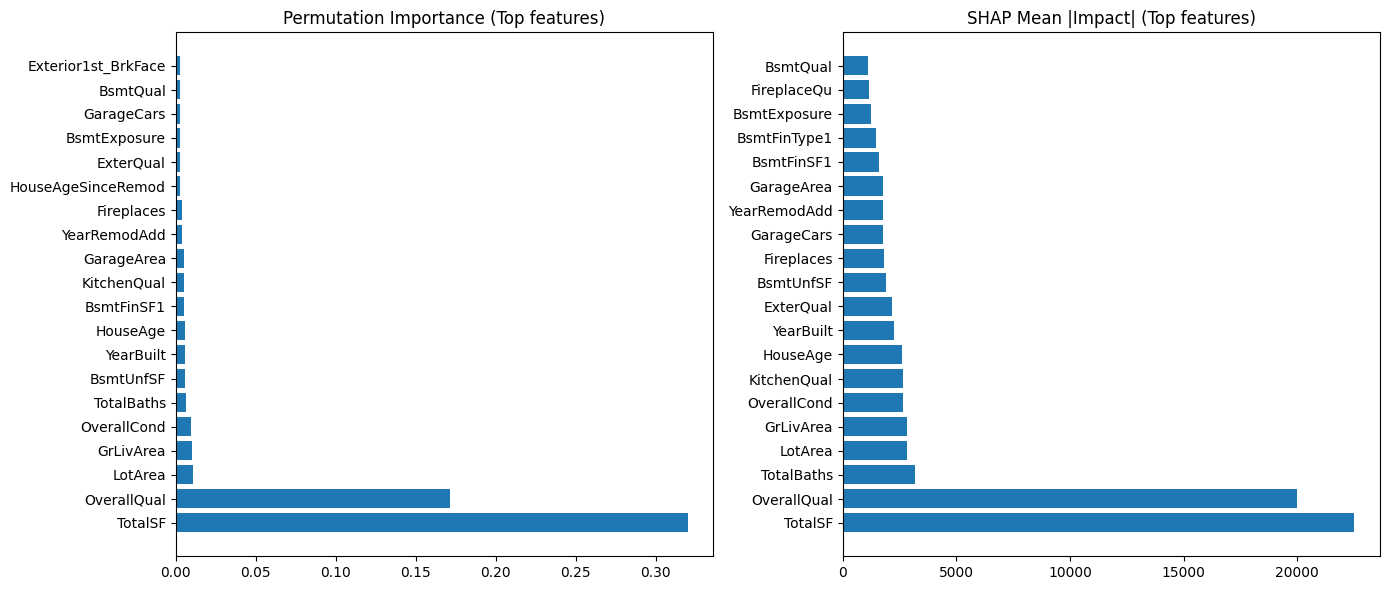

In [183]:
# ---- FAST importance plots without PolynomialFeatures ----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import shap

# 1) Use your already-preprocessed data (no polynomial expansion)
X = transformed_df  # includes your engineered & interaction features
y = Ames["SalePrice"]

# If you have a tuned HGB model object, use it; otherwise create a solid default:
try:
    hgb = best_histgb  # your tuned HistGradientBoostingRegressor
except NameError:
    from sklearn.ensemble import HistGradientBoostingRegressor
    hgb = HistGradientBoostingRegressor(
        learning_rate=0.05, max_iter=800, max_depth=6, max_bins=64,
        min_samples_leaf=10, random_state=42
    )

hgb.fit(X, y)

# 2) Permutation importance (keep repeats modest to stay fast)
perm = permutation_importance(
    hgb, X, y, n_repeats=5, random_state=42
)

# 3) SHAP for tree models (use TreeExplainer + a small sample to be fast)
explainer = shap.TreeExplainer(hgb)
sample_idx = np.random.RandomState(42).choice(len(X), size=min(800, len(X)), replace=False)
X_sample = X.iloc[sample_idx]
shap_values = explainer.shap_values(X_sample)

# 4) Plot helpers
def topk(arr, names, k=20):
    idx = np.argsort(arr)[-k:][::-1]
    return idx, np.array(names)[idx], arr[idx]

def plot_barh(ax, names, vals, title):
    ax.barh(range(len(vals)), vals)
    ax.set_yticks(range(len(vals)))
    ax.set_yticklabels(names)
    ax.set_title(title)

# 5) Build the four-panel figure (baseline vs interactions not needed here;
#     you’re already using the dataset that includes your chosen interactions)
k = 20
idx_p, names_p, vals_p = topk(perm.importances_mean, X.columns, k)
idx_s, names_s, vals_s = topk(np.abs(shap_values).mean(axis=0), X_sample.columns, k)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_barh(axes[0], names_p, vals_p, "Permutation Importance (Top features)")
plot_barh(axes[1], names_s, vals_s, "SHAP Mean |Impact| (Top features)")
plt.tight_layout()
plt.show()

Exception ignored in: <function ResourceTracker.__del__ at 0x10747dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102d65bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10696dbc0>
Traceback (most recent call last

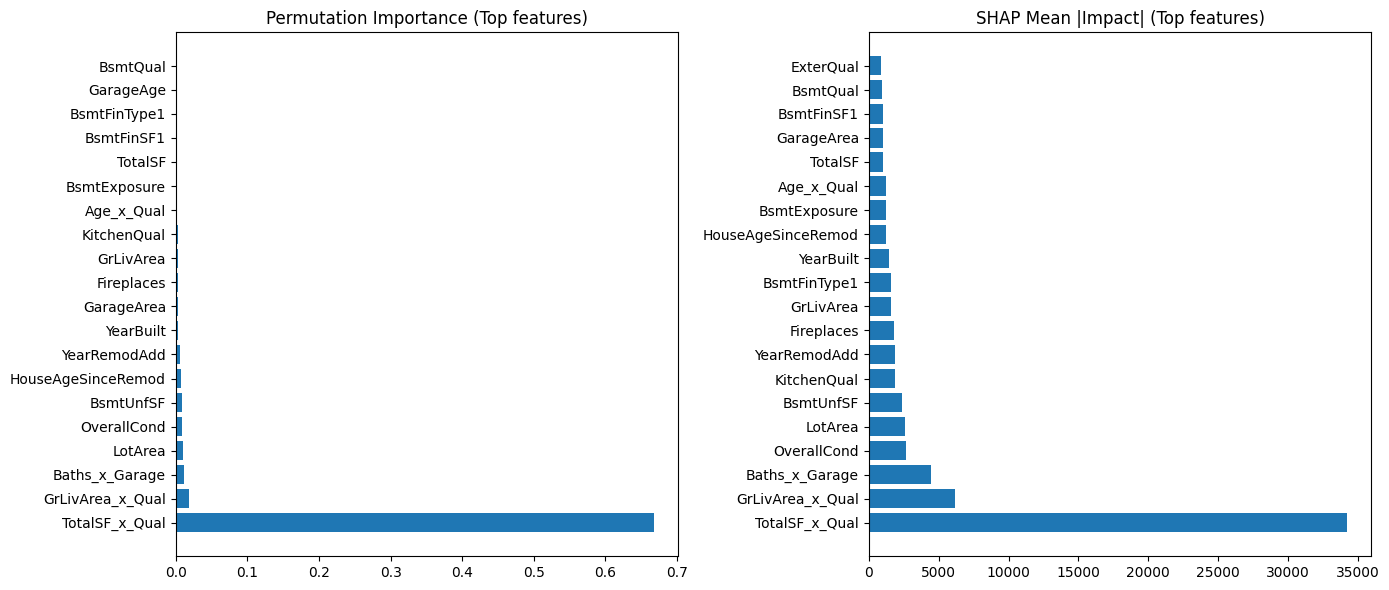

In [184]:
# ---- FAST importance plots without PolynomialFeatures ----
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import shap

# 1) Use your already-preprocessed data (no polynomial expansion)
X = transformed_df  # includes your engineered & interaction features
X = X_raw
y = Ames["SalePrice"]

# If you have a tuned HGB model object, use it; otherwise create a solid default:
try:
    hgb = best_histgb  # your tuned HistGradientBoostingRegressor
except NameError:
    from sklearn.ensemble import HistGradientBoostingRegressor
    hgb = HistGradientBoostingRegressor(
        learning_rate=0.05, max_iter=800, max_depth=6, max_bins=64,
        min_samples_leaf=10, random_state=42
    )

hgb.fit(X, y)

# 2) Permutation importance (keep repeats modest to stay fast)
perm = permutation_importance(
    hgb, X, y, n_repeats=5, random_state=42
)

# 3) SHAP for tree models (use TreeExplainer + a small sample to be fast)
explainer = shap.TreeExplainer(hgb)
sample_idx = np.random.RandomState(42).choice(len(X), size=min(800, len(X)), replace=False)
X_sample = X.iloc[sample_idx]
shap_values = explainer.shap_values(X_sample)

# 4) Plot helpers
def topk(arr, names, k=20):
    idx = np.argsort(arr)[-k:][::-1]
    return idx, np.array(names)[idx], arr[idx]

def plot_barh(ax, names, vals, title):
    ax.barh(range(len(vals)), vals)
    ax.set_yticks(range(len(vals)))
    ax.set_yticklabels(names)
    ax.set_title(title)

# 5) Build the four-panel figure (baseline vs interactions not needed here;
#     you’re already using the dataset that includes your chosen interactions)
k = 20
idx_p, names_p, vals_p = topk(perm.importances_mean, X.columns, k)
idx_s, names_s, vals_s = topk(np.abs(shap_values).mean(axis=0), X_sample.columns, k)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_barh(axes[0], names_p, vals_p, "Permutation Importance (Top features)")
plot_barh(axes[1], names_s, vals_s, "SHAP Mean |Impact| (Top features)")
plt.tight_layout()
plt.show()

In [488]:
# =========================
# Build a lean X_refined
# =========================
import pandas as pd

# 1) Core numeric features (keep if present)
core_numeric = [
    "TotalSF", "OverallQual", "GrLivArea", "TotalBaths",
    # keep ONE garage signal; we'll pick what's available below
    "GarageCars", "GarageArea",
    "LotArea", "YearBuilt", "YearRemodAdd",
    "HouseAge", "HouseAgeSinceRemod",
]

# 2) Targeted interactions (from your earlier engineering)
interactions = [
    "TotalSF_x_Qual", "GrLivArea_x_Qual",
    "Baths_x_Garage", "Age_x_Qual"
    # add "AgeRemod_x_Qual" here if you created it and want it
    # "AgeRemod_x_Qual",
]

# 3) Compact categorical dummies (prefix match)
#    - use the binned Neighborhood × quality combo (much leaner than full Neighborhood)
cat_prefixes = [
    "Neighborhood_QualBin_",
    "KitchenQual_", "BsmtQual_", "ExterQual_"
]

# ---- collect columns that actually exist in X_raw ----
present = set(X_raw.columns)

# pick one garage signal: prefer GarageCars, else GarageArea
garage_choice = "GarageCars" if "GarageCars" in present else ("GarageArea" if "GarageArea" in present else None)
core_keep = [c for c in core_numeric if c in present and c != "GarageCars" and c != "GarageArea"]
if garage_choice: 
    core_keep.append(garage_choice)

inter_keep = [c for c in interactions if c in present]

cat_keep = []
for p in cat_prefixes:
    cat_keep.extend([c for c in transformed_df.columns if c.startswith(p)])

keep_cols = core_keep + inter_keep + cat_keep
X_refined = X_raw[keep_cols].copy()

print(f"X_refined shape: {X_refined.shape}")
print("Kept (first 25):", keep_cols[:25])
missing = (set(core_numeric + interactions) - present)
if missing:
    print("Note: these requested columns were not found and were skipped:", sorted(missing))

X_refined shape: (2580, 78)
Kept (first 25): ['TotalSF', 'OverallQual', 'GrLivArea', 'TotalBaths', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'HouseAge', 'HouseAgeSinceRemod', 'GarageCars', 'TotalSF_x_Qual', 'GrLivArea_x_Qual', 'Baths_x_Garage', 'Age_x_Qual', 'Neighborhood_QualBin_Blmngtn_high', 'Neighborhood_QualBin_Blmngtn_med', 'Neighborhood_QualBin_Blueste_high', 'Neighborhood_QualBin_Blueste_med', 'Neighborhood_QualBin_BrDale_low', 'Neighborhood_QualBin_BrDale_med', 'Neighborhood_QualBin_BrkSide_low', 'Neighborhood_QualBin_BrkSide_med', 'Neighborhood_QualBin_ClearCr_high', 'Neighborhood_QualBin_ClearCr_low', 'Neighborhood_QualBin_ClearCr_med']


In [489]:
# Example: evaluate tuned HistGB or your linear baselines on X_refined
print(cv_eval_models_nonlinear(X_refined, y_final, cv=5, log_target=False, random_state=42).to_string(index=False))

KeyboardInterrupt: 

In [7]:
y_final = Ames.SalePrice

In [9]:
# === Compact feature set: top-K base features + engineered interactions ===
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer, r2_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingRegressor

RANDOM_STATE = 42
TOP_K_BASE = 90 # number of base (non-interaction) features to keep

# -------------------------------
# A) Start from your preprocessed table
# -------------------------------
X_base = transformed_df.copy()        # (one-hot + numeric, no scaling needed for trees)
y = y_final

# -------------------------------
# B) Add interaction features (only if both parents exist)
# -------------------------------
def safe_interaction(df, out_name, a, b):
    if a in df.columns and b in df.columns:
        df[out_name] = df[a] * df[b]

safe_interaction(X_base, "TotalSF_x_Qual",   "TotalSF",   "OverallQual")
safe_interaction(X_base, "GrLivArea_x_Qual", "GrLivArea", "OverallQual")
safe_interaction(X_base, "Baths_x_Garage",   "TotalBaths","GarageCars")
safe_interaction(X_base, "Age_x_Qual",       "HouseAge",  "OverallQual")
safe_interaction(X_base, "AgeRemod_x_Qual",  "HouseAgeSinceRemod", "OverallQual")

interaction_cols = [c for c in X_base.columns if c.endswith("_x_Qual") or c=="Baths_x_Garage"]

# -------------------------------
# C) Fit a fast tree on log-target (TTR) to rank BASE features
# -------------------------------
# Reasonable, stable HGB settings (close to what performed well for you)
hgb = HistGradientBoostingRegressor(
    learning_rate=0.03, max_iter=1200, max_depth=6,
    min_samples_leaf=20, max_bins=64, l2_regularization=0.0,
    random_state=RANDOM_STATE
)
ttr = TransformedTargetRegressor(regressor=hgb, func=np.log1p, inverse_func=np.expm1)

# Train once (fast)
ttr.fit(X_base, y)

# Try SHAP first; fall back to permutation importance if SHAP isn't available
try:
    import shap
    expl = shap.Explainer(ttr.regressor_, X_base, feature_names=X_base.columns)
    shap_vals = expl(X_base, check_additivity=False)
    shap_importance = np.abs(shap_vals.values).mean(axis=0)
    imp_series = pd.Series(shap_importance, index=X_base.columns).sort_values(ascending=False)
except Exception:
    # Permutation importance in R² space (dollar target because TTR inverts)
    perm = permutation_importance(ttr, X_base, y, n_repeats=8, random_state=RANDOM_STATE, n_jobs=-1, scoring="r2")
    imp_series = pd.Series(perm.importances_mean, index=X_base.columns).sort_values(ascending=False)

# Exclude interactions from the base top-K selection to avoid double bias
base_pool = [c for c in X_base.columns if c not in interaction_cols]
top_base = [c for c in imp_series.index if c in base_pool][:TOP_K_BASE]

# -------------------------------
# D) Build refined matrix = top base + interactions
# -------------------------------
keep_cols = list(dict.fromkeys(top_base + interaction_cols))  # preserve order, drop dups
X_refined = X_base[keep_cols].copy()

print(f"Refined feature set: {len(keep_cols)} columns "
      f"(base={len(top_base)}, interactions={len(interaction_cols)})")

# -------------------------------
# E) (Optional) quick CV check with the same HGB+TTR
# -------------------------------
def rmse(y_true, y_pred): 
    return float(np.sqrt(((y_true - y_pred) ** 2).mean()))

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
fold_rmses = []
oof = np.zeros(len(y), dtype=float)

for tr_idx, va_idx in kf.split(X_refined):
    X_tr, X_va = X_refined.iloc[tr_idx], X_refined.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    ttr.fit(X_tr, y_tr)
    pred = ttr.predict(X_va)
    fold_rmses.append(rmse(y_va, pred))
    oof[va_idx] = pred

print(f"Quick CV — RMSE mean: {np.mean(fold_rmses):,.0f}  std: {np.std(fold_rmses):,.0f}   R²: {r2_score(y, oof):.6f}")

# Your refined table is in X_refined

 99%|===================| 2551/2580 [00:42<00:00]        

Refined feature set: 95 columns (base=90, interactions=5)
Quick CV — RMSE mean: 21,778  std: 2,286   R²: 0.914789


In [10]:
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'max_bins': [32, 64, 128],
    'min_samples_leaf': [5, 10, 20],
    'max_iter': [1000, 1500, 2000],
    'learning_rate': [0.01, 0.03, 0.05],
    'l2_regularization': [0.0, 0.1, 0.3, 1.0],
}

histgb = HistGradientBoostingRegressor(random_state=42)

grid = GridSearchCV(
    histgb,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid.fit(X_refined, y)
print("Best params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)

KeyboardInterrupt: 

In [11]:
# ==== Lean HistGB tuner for X_refined ====
import time
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

RANDOM_STATE = 42
INNER_CV = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def make_ttr(est):
    return TransformedTargetRegressor(
        regressor=est,
        func=np.log1p,      # train on log price
        inverse_func=np.expm1
    )

# Tight ranges centered on what worked before
param_dist = {
    "regressor__learning_rate":   np.array([0.01, 0.02, 0.03, 0.04, 0.05]),
    "regressor__max_iter":        np.array([1000, 1400, 1600, 1800, 2000]),
    "regressor__max_depth":       [4, 6, 8, 10],
    "regressor__min_samples_leaf":[5, 10, 15, 20, 30],
    "regressor__max_bins":        [64, 96, 128],
    "regressor__l2_regularization":[0.0, 0.1, 0.3],
}

hgb = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
search = RandomizedSearchCV(
    estimator=make_ttr(hgb),
    param_distributions=param_dist,
    n_iter=22,                                # ~ fast but thorough
    scoring="neg_root_mean_squared_error",    # RMSE in $ (thanks to TTR)
    cv=INNER_CV,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

t0 = time.time()
search.fit(X_refined, y_final)   # <— use your refined matrix here
print(f"\nTuning elapsed: {time.time()-t0:.1f}s")

# Pretty print best
best_params = {k.replace("regressor__", ""): v for k, v in search.best_params_.items()}
print("Best HistGB params:", best_params)
print("Best CV RMSE ($):", -search.best_score_)

# === Optional: quick outer-CV check with your existing helper ===
# If you have cv_eval_models_nonlinear from earlier and want a leaderboard-style eval:
# models_tuned = [("HistGB_tuned", search.best_estimator_)]
# print(cv_eval_models_nonlinear(X_refined, y_final, cv=5, log_target=False,
#                                random_state=RANDOM_STATE, models=models_tuned)
#       .to_string(index=False))

Fitting 5 folds for each of 22 candidates, totalling 110 fits

Tuning elapsed: 29.4s
Best HistGB params: {'min_samples_leaf': 15, 'max_iter': np.int64(1800), 'max_depth': 4, 'max_bins': 128, 'learning_rate': np.float64(0.04), 'l2_regularization': 0.3}
Best CV RMSE ($): 21423.11575451983


In [12]:
# === Refined GridSearch for HistGradientBoostingRegressor ===
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor

# Assumes you already have:
#   X_refined  -> your current best feature matrix (pandas DataFrame or ndarray)
#   y          -> SalePrice (raw $ target)

RANDOM_STATE = 42
inner_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid_refined = {
    'max_depth': [3, 4, 5],
    'max_bins': [64, 96],
    'min_samples_leaf': [3, 5, 8],
    'max_iter': [800, 1000, 1200],
    'learning_rate': [0.04, 0.05, 0.06],
    'l2_regularization': [0.05, 0.1, 0.2],
}

histgb = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

grid_ref = GridSearchCV(
    estimator=histgb,
    param_grid=param_grid_refined,
    scoring='neg_root_mean_squared_error',   # RMSE in $-space
    cv=inner_cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid_ref.fit(X_refined, y)

best_rmse = -grid_ref.best_score_
print("\n[Refined GridSearch] Best params:", grid_ref.best_params_)
print(f"[Refined GridSearch] Best CV RMSE: {best_rmse:,.2f} $")

# ---- Quick confirmation CV with the best estimator ----
best_est = grid_ref.best_estimator_

rmse_scores = -cross_val_score(best_est, X_refined, y,
                               scoring='neg_root_mean_squared_error',
                               cv=inner_cv, n_jobs=-1)
r2_scores = cross_val_score(best_est, X_refined, y,
                            scoring='r2',
                            cv=inner_cv, n_jobs=-1)

print(f"\n[Confirm CV] RMSE mean: {rmse_scores.mean():,.0f}  std: {rmse_scores.std():,.0f}   "
      f"R² mean: {r2_scores.mean():.6f}")

Fitting 5 folds for each of 486 candidates, totalling 2430 fits

[Refined GridSearch] Best params: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_bins': 64, 'max_depth': 3, 'max_iter': 1200, 'min_samples_leaf': 8}
[Refined GridSearch] Best CV RMSE: 21,800.81 $

[Confirm CV] RMSE mean: 21,801  std: 3,610   R² mean: 0.914366


In [234]:
X_refined_K90 = X_refined

In [237]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import HistGradientBoostingRegressor

# Use your refined matrix for K=90
Xk = X_refined_K90      # <- make sure this variable holds your K=90 feature matrix
y  = Ames["SalePrice"]

# Best params from K=90 run
hgb_best = HistGradientBoostingRegressor(
    max_depth=3,
    max_iter=1200,
    learning_rate=0.06,
    min_samples_leaf=8,
    max_bins=64,
    l2_regularization=0.2,
    random_state=42
)

# RMSE scorer in $-space
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

cv10 = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(hgb_best, Xk, y, cv=cv10, scoring=rmse_scorer, n_jobs=-1)
rmse_mean = -scores.mean()
rmse_std  = scores.std()
print(f"[HGB @ K=90, 10-fold] RMSE mean: {rmse_mean:,.0f}   std: {rmse_std:,.0f}")

[HGB @ K=90, 10-fold] RMSE mean: 18,245   std: 2,636


Exception ignored in: <function ResourceTracker.__del__ at 0x107de9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


In [239]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

cv10 = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_scores, r2_scores = [], []

for train_idx, test_idx in cv10.split(Xk):
    X_train, X_test = Xk[train_idx], Xk[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    hgb_best.fit(X_train, y_train)
    preds = hgb_best.predict(X_test)
    
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    r2_scores.append(r2_score(y_test, preds))

print(f"[HGB @ K=90, 10-fold] "
      f"RMSE mean: {np.mean(rmse_scores):,.0f}   std: {np.std(rmse_scores):,.0f}   "
      f"R² mean: {np.mean(r2_scores):.6f}   std: {np.std(r2_scores):.6f}")

KeyError: "None of [Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,\n       ...\n       2568, 2569, 2570, 2571, 2572, 2573, 2575, 2576, 2577, 2579],\n      dtype='int64', length=2322)] are in the [columns]"

Exception ignored in: <function ResourceTracker.__del__ at 0x104d65bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104c65bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10a065bc0>
Traceback (most recent call last

In [240]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

cv10 = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_scores, r2_scores = [], []

# If y is a pandas Series, grab a NumPy view once
y_np = y.to_numpy() if hasattr(y, "to_numpy") else y

for train_idx, test_idx in cv10.split(Xk):
    # Rows by position for Xk (handles DataFrame or ndarray)
    if hasattr(Xk, "iloc"):
        X_train, X_test = Xk.iloc[train_idx], Xk.iloc[test_idx]
    else:
        X_train, X_test = Xk[train_idx], Xk[test_idx]
        
    # y as NumPy by position
    y_train, y_test = y_np[train_idx], y_np[test_idx]
    
    hgb_best.fit(X_train, y_train)
    preds = hgb_best.predict(X_test)
    
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, preds)))
    r2_scores.append(r2_score(y_test, preds))

print(
    f"[HGB @ K=90, 10-fold] "
    f"RMSE mean: {np.mean(rmse_scores):,.0f}   std: {np.std(rmse_scores):,.0f}   "
    f"R² mean: {np.mean(r2_scores):.6f}   std: {np.std(r2_scores):.6f}"
)

[HGB @ K=90, 10-fold] RMSE mean: 18,245   std: 2,636   R² mean: 0.932163   std: 0.020885


In [241]:
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor

# === tiny neighborhood around your current best ===
grid = {
    "learning_rate":       [0.04, 0.05, 0.06],
    "min_samples_leaf":    [5, 8, 10],
    "max_bins":            [64, 96],
    "max_depth":           [3, 4],
    "max_iter":            [1000, 1200, 1500],
    "l2_regularization":   [0.05, 0.1, 0.2],
}

def cv_rmse_r2(est, X, y, n_splits=10, seed=42):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    rmses, r2s = [], []
    y_np = y.to_numpy() if hasattr(y, "to_numpy") else y
    for tr, va in cv.split(X):
        X_tr = X.iloc[tr] if hasattr(X, "iloc") else X[tr]
        X_va = X.iloc[va] if hasattr(X, "iloc") else X[va]
        y_tr, y_va = y_np[tr], y_np[va]
        est.fit(X_tr, y_tr)
        pred = est.predict(X_va)
        rmses.append(np.sqrt(mean_squared_error(y_va, pred)))
        r2s.append(r2_score(y_va, pred))
    return (float(np.mean(rmses)), float(np.std(rmses)),
            float(np.mean(r2s)),  float(np.std(r2s)))

best = {"rmse": float("inf")}
for params in product(*grid.values()):
    p = dict(zip(grid.keys(), params))
    est = HistGradientBoostingRegressor(random_state=42, **p)
    rm, rsd, r2m, r2sd = cv_rmse_r2(est, Xk, y, n_splits=10, seed=42)
    if rm < best["rmse"]:
        best = {"rmse": rm, "rmse_std": rsd, "r2": r2m, "r2_std": r2sd, "params": p}

print("[HGB micro-refine @ K=90, 10-fold]")
print(f"Best params: {best['params']}")
print(f"RMSE mean: {best['rmse']:,.0f}   std: {best['rmse_std']:,.0f}   "
      f"R² mean: {best['r2']:.6f}   std: {best['r2_std']:.6f}")

KeyboardInterrupt: 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

t0 = time.time()
Xtr, Xva, ytr, yva = train_test_split(Xk, y, test_size=0.2, random_state=42, shuffle=True)

hgb_best.fit(Xtr, ytr)
pred = hgb_best.predict(Xva)

rmse = float(np.sqrt(mean_squared_error(yva, pred)))
r2   = float(r2_score(yva, pred))

print(f"[HGB @ K={Xk.shape[1]}, 80/20 split] RMSE: {rmse:,.0f}   R²: {r2:.6f}   ({time.time()-t0:.2f}s)")

NameError: name 'Xk' is not defined

In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np, time

t0 = time.time()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores, r2_scores = [], []
y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)

for tr_idx, va_idx in kf.split(Xk):
    # robust positional indexing for DataFrame or ndarray
    X_tr = Xk.iloc[tr_idx] if hasattr(Xk, "iloc") else Xk[tr_idx]
    X_va = Xk.iloc[va_idx] if hasattr(Xk, "iloc") else Xk[va_idx]
    y_tr, y_va = y_np[tr_idx], y_np[va_idx]

    hgb_best.fit(X_tr, y_tr)
    pred = hgb_best.predict(X_va)

    rmse_scores.append(np.sqrt(mean_squared_error(y_va, pred)))
    r2_scores.append(r2_score(y_va, pred))

print(f"[HGB @ K={Xk.shape[1]}, 5-fold] "
      f"RMSE mean: {np.mean(rmse_scores):,.0f}   std: {np.std(rmse_scores):,.0f}   "
      f"R² mean: {np.mean(r2_scores):.6f}   std: {np.std(r2_scores):.6f}   "
      f"({time.time()-t0:.2f}s)")

NameError: name 'Xk' is not defined

In [25]:
import time
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone

def _to_numpy(a):
    """Safely get a numpy array from pandas/ndarray with positional indexing compatibility."""
    return a.to_numpy() if hasattr(a, "to_numpy") else np.asarray(a)

def _rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def quick_eval(
    estimator,
    X,
    y,
    *,
    mode="cv5",              # "holdout", "cvK" (e.g. "cv5", "cv10")
    random_state=42,
    test_size=0.2,          # used for holdout
    shuffle=True,
    return_oof=False,       # for CV: return out-of-fold preds
    verbose=True
):
    """
    Fast evaluator for regressors.
      - mode="holdout": single 80/20 (or set test_size) split
      - mode="cvK": K-fold CV (e.g. "cv5", "cv10")
    Prints a compact summary and returns a results dict.
    Does NOT mutate the passed estimator (uses clone).
    """
    t0 = time.time()
    X_np = X if not hasattr(X, "iloc") else X.to_numpy()
    y_np = _to_numpy(y)

    results = {}

    if mode.lower() == "holdout":
        X_tr, X_te, y_tr, y_te = train_test_split(
            X_np, y_np, test_size=test_size, shuffle=shuffle, random_state=random_state
        )
        est = clone(estimator)
        est.fit(X_tr, y_tr)
        preds = est.predict(X_te)

        rmse = _rmse(y_te, preds)
        r2   = float(r2_score(y_te, preds))

        results.update({
            "mode": "holdout",
            "rmse": rmse,
            "r2": r2,
            "elapsed_sec": time.time() - t0,
            "estimator": est
        })

        if verbose:
            print(f"[{estimator.__class__.__name__} @ holdout {int((1-test_size)*100)}/{int(test_size*100)}] "
                  f"RMSE: {rmse:,.0f}   R²: {r2:.6f}   ({results['elapsed_sec']:.2f}s)")

        return results

    # ---- CV path ----
    if mode.lower().startswith("cv"):
        try:
            k = int(mode.lower().replace("cv", ""))
        except Exception:
            raise ValueError("For CV, use mode like 'cv5', 'cv10', etc.")

        kf = KFold(n_splits=k, shuffle=shuffle, random_state=random_state)
        fold_rmses, fold_r2 = [], []
        oof = np.zeros(len(y_np), dtype=float) if return_oof else None

        for tr_idx, va_idx in kf.split(X_np):
            X_tr, X_va = X_np[tr_idx], X_np[va_idx]
            y_tr, y_va = y_np[tr_idx], y_np[va_idx]

            est = clone(estimator)
            est.fit(X_tr, y_tr)
            pred = est.predict(X_va)

            fold_rmses.append(_rmse(y_va, pred))
            fold_r2.append(r2_score(y_va, pred))
            if return_oof:
                oof[va_idx] = pred

        rmse_mean, rmse_std = float(np.mean(fold_rmses)), float(np.std(fold_rmses, ddof=0))
        r2_mean,   r2_std   = float(np.mean(fold_r2)),   float(np.std(fold_r2, ddof=0))

        results.update({
            "mode": f"cv{k}",
            "rmse_mean": rmse_mean,
            "rmse_std": rmse_std,
            "r2_mean": r2_mean,
            "r2_std": r2_std,
            "elapsed_sec": time.time() - t0,
        })
        if return_oof:
            results["oof_pred"] = oof

        if verbose:
            print(f"[{estimator.__class__.__name__} @ {k}-fold] "
                  f"RMSE mean: {rmse_mean:,.0f}   std: {rmse_std:,.0f}   "
                  f"R² mean: {r2_mean:.6f}   std: {r2_std:.6f}   "
                  f"({results['elapsed_sec']:.2f}s)")

        return results

    raise ValueError("mode must be 'holdout' or like 'cv5', 'cv10', ...")

In [26]:
# Example with your tuned HistGradientBoostingRegressor named hgb_best
# Xk: your K-best feature matrix, y: target in dollars

# quick 80/20 check:
res_holdout = quick_eval(hgb_best, Xk, y, mode="holdout")

# 5-fold CV confirmation:
res_cv5 = quick_eval(hgb_best, Xk, y, mode="cv5")

# 10-fold (only when you want the tightest estimate)
res_cv10 = quick_eval(hgb_best, Xk, y, mode="cv10")

NameError: name 'hgb_best' is not defined

In [22]:
# ===== CatBoost baseline + blend with your tuned HistGB =====
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

from catboost import CatBoostRegressor

# ---- tiny helpers ----
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def kfold_oof(model_factory, X, y, *, n_splits=5, random_state=42, verbose=False):
    from catboost import CatBoostRegressor  # local import so this stays optional
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    y = np.asarray(y)
    oof = np.zeros_like(y, dtype=float)
    fold_rmses, fold_r2 = [], []

    for i, (tr, va) in enumerate(kf.split(X), 1):
        X_tr = X.iloc[tr] if hasattr(X, "iloc") else X[tr]
        X_va = X.iloc[va] if hasattr(X, "iloc") else X[va]
        y_tr, y_va = y[tr], y[va]

        m = model_factory()

        if isinstance(m, CatBoostRegressor):
            # CatBoost supports eval_set/use_best_model
            m.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, verbose=False)
        else:
            # sklearn models: just fit (use internal early stopping if enabled)
            m.fit(X_tr, y_tr)

        pred = m.predict(X_va)
        oof[va] = pred
        fold_rmses.append(rmse(y_va, pred))
        fold_r2.append(r2_score(y_va, pred))
        if verbose:
            print(f"[Fold {i}] RMSE={fold_rmses[-1]:,.0f}  R²={fold_r2[-1]:.5f}")

    return (oof,
            float(np.mean(fold_rmses)), float(np.std(fold_rmses, ddof=0)),
            float(np.mean(fold_r2)),   float(np.std(fold_r2,   ddof=0)))

# ---- A) CatBoost baseline (fast, strong for tabular) ----
# Xk : your refined feature matrix (DataFrame or ndarray)
# y  : target in $ space (no log)
# hgb_best : your tuned HistGradientBoostingRegressor (already in $ space)

def catboost_factory():
    return CatBoostRegressor(
        loss_function="RMSE",
        iterations=2000,            # will stop early
        learning_rate=0.05,
        depth=6,                    # try 6–8 if you want to push a bit
        l2_leaf_reg=3.0,
        subsample=0.8,
        colsample_bylevel=0.8,
        random_state=42,
        early_stopping_rounds=100,
        verbose=False,
        thread_count=-1             # use all threads; no joblib child procs
    )

print("\n=== CatBoost baseline (5-fold OOF) ===")
cb_oof, cb_rm, cb_sd, cb_r2m, cb_r2sd = kfold_oof(catboost_factory, Xk, y, n_splits=5, random_state=42)
print(f"CatBoost  RMSE mean: {cb_rm:,.0f}   std: {cb_sd:,.0f}   R² mean: {cb_r2m:.6f}   std: {cb_r2sd:.6f}")

# ---- B) OOF for your tuned HGB (so we can blend apples-to-apples) ----
def hgb_factory():
    from sklearn.ensemble import HistGradientBoostingRegressor
    params = hgb_best.get_params()
    # enable internal early stopping if not already set
    params.setdefault("early_stopping", True)
    params.setdefault("validation_fraction", 0.1)
    params.setdefault("n_iter_no_change", 50)
    return HistGradientBoostingRegressor(**params)

print("\n=== HistGB (tuned) 5-fold OOF ===")
hgb_oof, hgb_rm, hgb_sd, hgb_r2m, hgb_r2sd = kfold_oof(hgb_factory, Xk, y, n_splits=5, random_state=42)
print(f"HistGB     RMSE mean: {hgb_rm:,.0f}   std: {hgb_sd:,.0f}   R² mean: {hgb_r2m:.6f}   std: {hgb_r2sd:.6f}")

# ---- C) Simple weight search to blend the two OOF predictions ----
weights = np.linspace(0.0, 1.0, 101)  # weight on CatBoost (1-w on HGB)
rmses = []
for w in weights:
    blend = w*cb_oof + (1-w)*hgb_oof
    rmses.append(rmse(y, blend))
w_best = float(weights[int(np.argmin(rmses))])
rmse_best = float(np.min(rmses))
r2_best = float(r2_score(y, w_best*cb_oof + (1-w_best)*hgb_oof))

print("\n=== Blending (OOF) ===")
print(f"Best weight on CatBoost: w = {w_best:.2f}")
print(f"Blended OOF RMSE: {rmse_best:,.0f}   R²: {r2_best:.6f}")

# ---- D) Train final models on full data + make a predict() for the blend ----
cb_full = catboost_factory().fit(Xk, y, eval_set=(Xk, y), use_best_model=False, verbose=False)
hgb_full = hgb_factory().fit(Xk, y)

def predict_blend(X):
    """Predict with the full-data models and the learned blend weight."""
    p_cb  = cb_full.predict(X)
    p_hgb = hgb_full.predict(X)
    return w_best*p_cb + (1-w_best)*p_hgb

# Example: in-sample blended performance (sanity check)
blend_in = predict_blend(Xk)
print("\n=== Full-data fit (sanity check) ===")
print(f"In-sample RMSE: {rmse(y, blend_in):,.0f}   R²: {r2_score(y, blend_in):.6f}")


=== CatBoost baseline (5-fold OOF) ===


NameError: name 'Xk' is not defined

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Xk, y: your refined feature matrix and target
X_tr, X_te, y_tr, y_te = train_test_split(Xk, y, test_size=0.2, random_state=42)

# Refit best single models on training split (CatBoost + HGB)
cat_params = dict(
    loss_function="RMSE",
    depth=8, learning_rate=0.05, l2_leaf_reg=6.0,
    iterations=6000, early_stopping_rounds=200,
    subsample=0.7, colsample_bylevel=0.7,
    random_seed=42, verbose=False, allow_writing_files=False
)
from catboost import CatBoostRegressor
cat_tr = CatBoostRegressor(**cat_params)
cat_tr.fit(X_tr, y_tr, eval_set=(X_te, y_te), use_best_model=True)

from sklearn.ensemble import HistGradientBoostingRegressor
hgb_params = hgb_best.get_params() if "hgb_best" in globals() else {
    "max_depth": 3, "learning_rate": 0.06, "max_iter": 1200,
    "min_samples_leaf": 8, "l2_regularization": 0.2,
    "max_bins": 96, "early_stopping": True, "validation_fraction": 0.1,
    "n_iter_no_change": 50, "random_state": 42
}
hgb_tr = HistGradientBoostingRegressor(**hgb_params)
hgb_tr.fit(X_tr, y_tr)

# Predictions
p_cat = cat_tr.predict(X_te)
p_hgb = hgb_tr.predict(X_te)

# Use the OOF-optimal weight you found (0.72) and also check a quick sweep around it
def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))
ws = np.linspace(0.6, 0.85, 11)
best = min(((w, rmse(y_te, w*p_cat + (1-w)*p_hgb)) for w in ws), key=lambda t:t[1])
w_star, rmse_star = best
p_blend = w_star * p_cat + (1 - w_star) * p_hgb

print(f"[Holdout] CatBoost: RMSE {rmse(y_te,p_cat):,.0f}  R² {r2_score(y_te,p_cat):.6f}")
print(f"[Holdout] HGB     : RMSE {rmse(y_te,p_hgb):,.0f}  R² {r2_score(y_te,p_hgb):.6f}")
print(f"[Holdout] Blend(w={w_star:.2f}): RMSE {rmse_star:,.0f}  R² {r2_score(y_te,p_blend):.6f}")

NameError: name 'Xk' is not defined

In [20]:
# --- Ultra-fast CatBoost micro-tune (holdout-only) ---
import numpy as np, time
from itertools import product
from random import Random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

def rmse(y_true, y_pred): 
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def fast_catboost_holdout_tune(
    X, y, *,
    n_candidates=12,
    iterations=5000,
    early_stopping_rounds=200,
    random_state=42,
    sample_rows=None,          # e.g. 1800 to tune on a subset; None = all rows
    param_space=None
):
    t0 = time.time()
    rng = Random(random_state)

    # optional row subsample for speed
    if sample_rows is not None and sample_rows < len(y):
        idx = np.random.RandomState(random_state).choice(len(y), size=sample_rows, replace=False)
        Xs, ys = X.iloc[idx], y.iloc[idx]
    else:
        Xs, ys = X, y

    # single holdout split
    X_tr, X_va, y_tr, y_va = train_test_split(Xs, ys, test_size=0.2, random_state=random_state)

    # small, sensible search space (feel free to tweak ranges)
    if param_space is None:
        param_space = {
            "depth":              [6, 7, 8, 9],
            "learning_rate":      [0.035, 0.045, 0.055],
            "l2_leaf_reg":        [3.0, 6.0, 10.0],
            "subsample":          [0.65, 0.75, 0.85],
            "colsample_bylevel":  [0.6, 0.7, 0.8],
        }

    # random subset of the cartesian product
    all_grid = list(product(*param_space.values()))
    rng.shuffle(all_grid)
    grid = all_grid[:n_candidates]

    best_rmse, best_params, best_model = float("inf"), None, None

    for combo in grid:
        params = {k: v for k, v in zip(param_space.keys(), combo)}
        model = CatBoostRegressor(
            loss_function="RMSE",
            iterations=iterations,
            early_stopping_rounds=early_stopping_rounds,
            random_seed=random_state,
            allow_writing_files=False,
            verbose=False,
            thread_count=-1,
            **params
        )
        model.fit(X_tr, y_tr, eval_set=(X_va, y_va), use_best_model=True, verbose=False)
        preds = model.predict(X_va)
        score = rmse(y_va, preds)
        if score < best_rmse:
            best_rmse, best_params, best_model = score, params, model

    # refit best on full data at the best iteration discovered
    best_iters = int(best_model.get_best_iteration() or iterations)
    final_model = CatBoostRegressor(
        loss_function="RMSE",
        iterations=best_iters,
        random_seed=random_state,
        allow_writing_files=False,
        verbose=False,
        thread_count=-1,
        **best_params
    ).fit(X, y)

    elapsed = time.time() - t0
    print(f"[Fast CB tune] Best holdout RMSE: {best_rmse:,.0f} | params={best_params} | iters={best_iters}  ({elapsed:.2f}s)")
    return final_model, best_params, best_rmse, best_iters

# === run it ===
# Use your refined matrix & target: Xk, y
cb_fast, cb_params, cb_rmse, cb_iters = fast_catboost_holdout_tune(
    Xk, y,
    n_candidates=14,           # try 8–20 depending on patience
    iterations=5000,
    early_stopping_rounds=200,
    sample_rows=None,          # or e.g. 1800 to be even faster
    random_state=42
)

# quick 80/20 report for the chosen model
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(Xk, y, test_size=0.2, random_state=42)
cb_fast.fit(X_tr, y_tr, eval_set=(X_te, y_te), use_best_model=True, verbose=False)
preds = cb_fast.predict(X_te)
print(f"[CatBoost fast] Holdout RMSE: {rmse(y_te, preds):,.0f}   R²: {r2_score(y_te, preds):.6f}")

NameError: name 'Xk' is not defined

In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmses, r2s = [], []
for tr, va in kf.split(Xk):
    m = CatBoostRegressor(
        loss_function="RMSE",
        iterations=cb_iters,  # fixed
        random_seed=42, allow_writing_files=False, verbose=False, thread_count=-1,
        **cb_params
    ).fit(Xk.iloc[tr], y.iloc[tr])
    p = m.predict(Xk.iloc[va])
    rmses.append(rmse(y.iloc[va], p))
    r2s.append(r2_score(y.iloc[va], p))
print(f"[CatBoost quick 5-fold] RMSE mean: {np.mean(rmses):,.0f}  std: {np.std(rmses):,.0f}  "
      f"R² mean: {np.mean(r2s):.6f}  std: {np.std(r2s):.6f}")

NameError: name 'Xk' is not defined